In [30]:
import os, sys
import time
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, plot_importance, Booster
import pickle
import joblib
from tqdm import tqdm

# z position of STRAW chambers and MNP33 magnet
STRAW1Z=183507.9
STRAW2Z=194062.9
STRAW3Z=204449.9
STRAW4Z=218875.7
MNP33Z=197645

# Load up root file as pandas dataframe format

In [31]:
filename="rootfiles/MC_k2pi_noov.20250410.sel.skim.root"
treename="Preselection"
variables=["KDecayZvertex","PiChDecay","PiChDecayZvertex","NGoodPi0","TrackPID",
           "trackTime","KTAGTime","MUV3Time","Pi0Time",
           "KPiZeroSTRAW1Pos","KPiZeroSTRAW2Pos","KPiZeroSTRAW3Pos","KPiZeroSTRAW4Pos",
           "TrackSTRAW1Pos","TrackSTRAW2Pos","TrackSTRAW3Pos","TrackSTRAW4Pos",
           "KPiZeroMomentum","TrackMomentum","TrackMomentumBeforeFit",
           "TrackSlopeXBeforeMagnet","TrackSlopeYBeforeMagnet","TrackSlopeXAfterMagnet","TrackSlopeYAfterMagnet",
           "TrackSlopeXBeforeFit","TrackSlopeYBeforeFit",
           "TrackChi2","MMSKPi_SG","MMSKMu_SG","MMSKPiZero_SG","MMSKPiZeroMu_SG",
           "TrackLKrEoP","TrackCDA","DeltaAngle_KPiZero_trackStraw12_SG","DeltaAngle_KPiZero_trackStraw34_SG",
           "PiMuZvtx","PiMuCDA","TrackTotalQuality","TrackHoughQuality"]

# Selecting events with exactly one good pi0 candidate
for df in uproot.iterate(filename+":"+treename, variables, step_size=5000000, library='pd'):
    df_1pi0region=df.loc[(df['NGoodPi0']==1) & (df['MMSKPi_SG']>-900) & (df['MMSKMu_SG']>-900)]
    break

print("Number of events loaded: ", len(df_1pi0region))

# Get x, y, z coordinates of the STRAW hits for the KPi0 and track
df_1pi0region = df_1pi0region.copy()
df_1pi0region['KPiZeroSTRAW1PosfX'] = df_1pi0region['KPiZeroSTRAW1Pos'].apply(lambda d: d['fX'])
df_1pi0region['KPiZeroSTRAW1PosfY'] = df_1pi0region['KPiZeroSTRAW1Pos'].apply(lambda d: d['fY'])
df_1pi0region['KPiZeroSTRAW1PosfZ'] = df_1pi0region['KPiZeroSTRAW1Pos'].apply(lambda d: d['fZ'])
df_1pi0region['KPiZeroSTRAW2PosfX'] = df_1pi0region['KPiZeroSTRAW2Pos'].apply(lambda d: d['fX'])
df_1pi0region['KPiZeroSTRAW2PosfY'] = df_1pi0region['KPiZeroSTRAW2Pos'].apply(lambda d: d['fY'])
df_1pi0region['KPiZeroSTRAW2PosfZ'] = df_1pi0region['KPiZeroSTRAW2Pos'].apply(lambda d: d['fZ'])
df_1pi0region['KPiZeroSTRAW3PosfX'] = df_1pi0region['KPiZeroSTRAW3Pos'].apply(lambda d: d['fX'])
df_1pi0region['KPiZeroSTRAW3PosfY'] = df_1pi0region['KPiZeroSTRAW3Pos'].apply(lambda d: d['fY'])
df_1pi0region['KPiZeroSTRAW3PosfZ'] = df_1pi0region['KPiZeroSTRAW3Pos'].apply(lambda d: d['fZ'])
df_1pi0region['KPiZeroSTRAW4PosfX'] = df_1pi0region['KPiZeroSTRAW4Pos'].apply(lambda d: d['fX'])
df_1pi0region['KPiZeroSTRAW4PosfY'] = df_1pi0region['KPiZeroSTRAW4Pos'].apply(lambda d: d['fY'])
df_1pi0region['KPiZeroSTRAW4PosfZ'] = df_1pi0region['KPiZeroSTRAW4Pos'].apply(lambda d: d['fZ'])
df_1pi0region['TrackSTRAW1PosfX'] = df_1pi0region['TrackSTRAW1Pos'].apply(lambda d: d['fX'])
df_1pi0region['TrackSTRAW1PosfY'] = df_1pi0region['TrackSTRAW1Pos'].apply(lambda d: d['fY'])
df_1pi0region['TrackSTRAW1PosfZ'] = df_1pi0region['TrackSTRAW1Pos'].apply(lambda d: d['fZ'])
df_1pi0region['TrackSTRAW2PosfX'] = df_1pi0region['TrackSTRAW2Pos'].apply(lambda d: d['fX'])
df_1pi0region['TrackSTRAW2PosfY'] = df_1pi0region['TrackSTRAW2Pos'].apply(lambda d: d['fY'])
df_1pi0region['TrackSTRAW2PosfZ'] = df_1pi0region['TrackSTRAW2Pos'].apply(lambda d: d['fZ'])
df_1pi0region['TrackSTRAW3PosfX'] = df_1pi0region['TrackSTRAW3Pos'].apply(lambda d: d['fX'])
df_1pi0region['TrackSTRAW3PosfY'] = df_1pi0region['TrackSTRAW3Pos'].apply(lambda d: d['fY'])
df_1pi0region['TrackSTRAW3PosfZ'] = df_1pi0region['TrackSTRAW3Pos'].apply(lambda d: d['fZ'])
df_1pi0region['TrackSTRAW4PosfX'] = df_1pi0region['TrackSTRAW4Pos'].apply(lambda d: d['fX'])
df_1pi0region['TrackSTRAW4PosfY'] = df_1pi0region['TrackSTRAW4Pos'].apply(lambda d: d['fY'])
df_1pi0region['TrackSTRAW4PosfZ'] = df_1pi0region['TrackSTRAW4Pos'].apply(lambda d: d['fZ'])

# Check columns saved in the dataframe
print(df_1pi0region.keys())


Number of events loaded:  547069
Index(['KDecayZvertex', 'PiChDecay', 'PiChDecayZvertex', 'NGoodPi0',
       'TrackPID', 'trackTime', 'KTAGTime', 'MUV3Time', 'Pi0Time',
       'KPiZeroSTRAW1Pos', 'KPiZeroSTRAW2Pos', 'KPiZeroSTRAW3Pos',
       'KPiZeroSTRAW4Pos', 'TrackSTRAW1Pos', 'TrackSTRAW2Pos',
       'TrackSTRAW3Pos', 'TrackSTRAW4Pos', 'KPiZeroMomentum', 'TrackMomentum',
       'TrackMomentumBeforeFit', 'TrackSlopeXBeforeMagnet',
       'TrackSlopeYBeforeMagnet', 'TrackSlopeXAfterMagnet',
       'TrackSlopeYAfterMagnet', 'TrackSlopeXBeforeFit',
       'TrackSlopeYBeforeFit', 'TrackChi2', 'MMSKPi_SG', 'MMSKMu_SG',
       'MMSKPiZero_SG', 'MMSKPiZeroMu_SG', 'TrackLKrEoP', 'TrackCDA',
       'DeltaAngle_KPiZero_trackStraw12_SG',
       'DeltaAngle_KPiZero_trackStraw34_SG', 'PiMuZvtx', 'PiMuCDA',
       'TrackTotalQuality', 'TrackHoughQuality', 'KPiZeroSTRAW1PosfX',
       'KPiZeroSTRAW1PosfY', 'KPiZeroSTRAW1PosfZ', 'KPiZeroSTRAW2PosfX',
       'KPiZeroSTRAW2PosfY', 'KPiZeroSTRAW2PosfZ

# Truth Decay Vertex of K2pi event with PiMu Decay

There are 2.64% of events in which the pion did not decay.


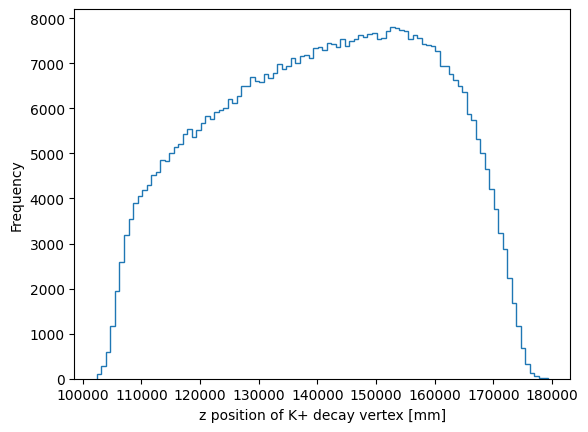

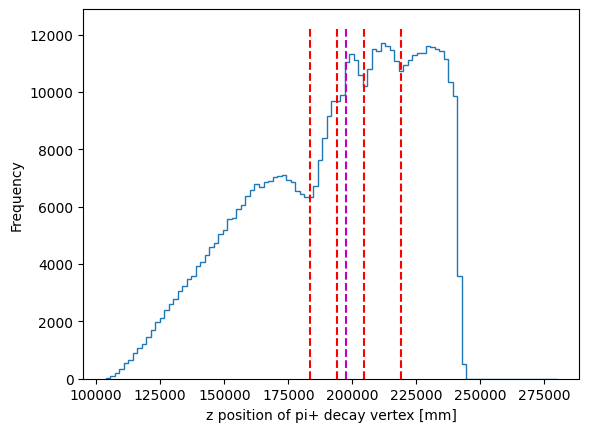

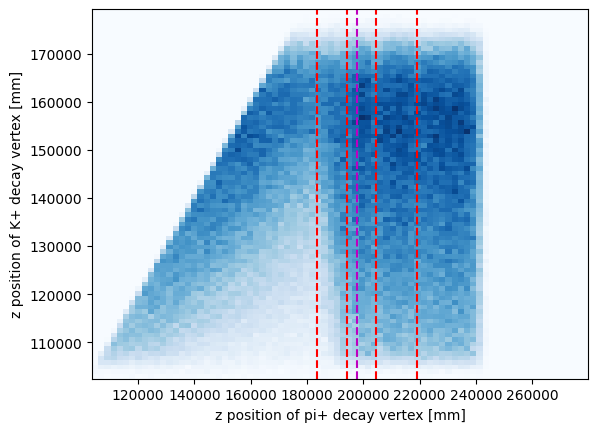

In [32]:
print("There are {:.2f}% of events in which the pion did not decay.".format(100.*len(df_1pi0region.loc[df_1pi0region['PiChDecay']==0])/len(df_1pi0region)))

ax=df_1pi0region['KDecayZvertex'].plot.hist(bins=100,histtype='step')
ax.set_xlabel("z position of K+ decay vertex [mm]")
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/truth_KdecayZvtx.pdf")

ax=df_1pi0region.loc[df_1pi0region['PiChDecay']==1]['PiChDecayZvertex'].plot.hist(bins=100,histtype='step')
ax.set_xlabel("z position of pi+ decay vertex [mm]")
ymin=ax.get_ylim()[0]
ymax=ax.get_ylim()[1]
plt.vlines(STRAW1Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW2Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW3Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW4Z, ymin, ymax, 'r', '--')
plt.vlines(MNP33Z, ymin, ymax, 'm', '--')
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/truth_PiMudecayZvtx.pdf")

fig, ax = plt.subplots(1)
plt.hist2d(df_1pi0region.loc[df_1pi0region['PiChDecay']==1]["PiChDecayZvertex"], df_1pi0region.loc[df_1pi0region['PiChDecay']==1]["KDecayZvertex"], bins=80, cmap='Blues')
ax.set_xlabel("z position of pi+ decay vertex [mm]")
ax.set_ylabel("z position of K+ decay vertex [mm]")
ymin=ax.get_ylim()[0]
ymax=ax.get_ylim()[1]
plt.vlines(STRAW1Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW2Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW3Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW4Z, ymin, ymax, 'r', '--')
plt.vlines(MNP33Z, ymin, ymax, 'm', '--')
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/truth_PiMudecayZvtx_vs_KdecayZvtx.pdf")

# Timing info 

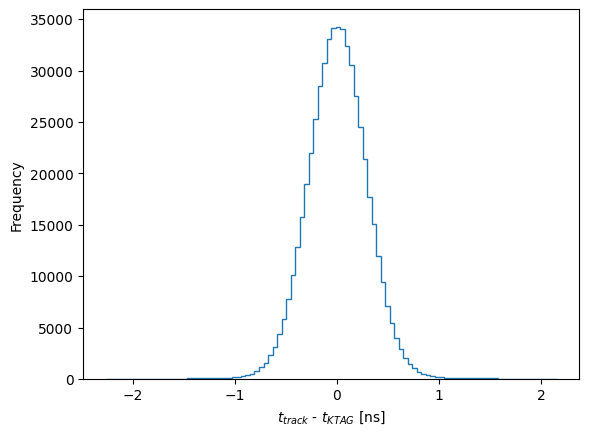

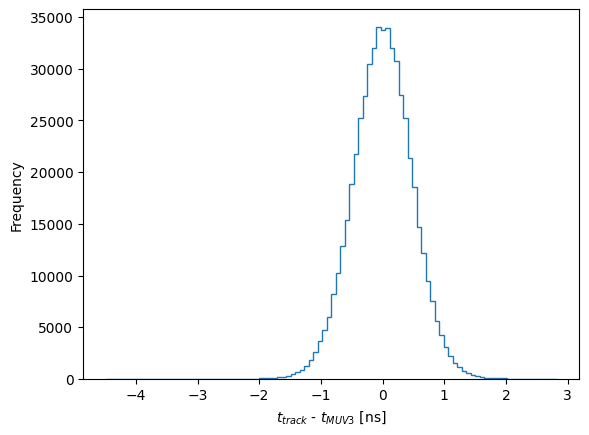

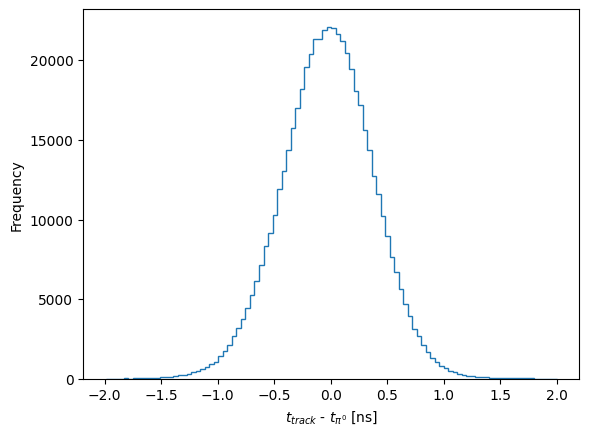

In [33]:
ax=(df_1pi0region['trackTime']-df_1pi0region['KTAGTime']).plot.hist(bins=100,histtype='step')
ax.set_xlabel(r"$t_{track}$ - $t_{KTAG}$ [ns]")
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/timeTrack-timeKTAG.pdf")

ax=(df_1pi0region['trackTime']-df_1pi0region['MUV3Time']).plot.hist(bins=100,histtype='step')
ax.set_xlabel(r"$t_{track}$ - $t_{MUV3}$ [ns]")
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/timeTrack-timeMUV3.pdf")

ax=(df_1pi0region['trackTime']-df_1pi0region['Pi0Time']).plot.hist(bins=100,histtype='step')
ax.set_xlabel(r"$t_{track}$ - $t_{\pi^{0}}$ [ns]")
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/timeTrack-timePi0.pdf")

# Missing mass square vs Track momentum

In [34]:
def drawPlot_mms_vs_trkmom(key,rmin=None,rmax=None):
    if(rmin!=None and rmax!=None):
        df_1pi0region_reduced=df_1pi0region.loc[(df_1pi0region[key]>rmin) & (df_1pi0region[key]<rmax)]
    elif(rmin!=None):
        df_1pi0region_reduced=df_1pi0region.loc[df_1pi0region[key]>rmin]
    elif(rmax!=None):
        df_1pi0region_reduced=df_1pi0region.loc[df_1pi0region[key]<rmax]
    else:
        df_1pi0region_reduced=df_1pi0region
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

    ax1.hist2d(df_1pi0region_reduced[key], df_1pi0region_reduced["TrackMomentum"], bins=80, cmap='GnBu')
    ax1.set_xlabel(key)
    ax1.set_ylabel("TrackMomentum")

    ax2.hist(df_1pi0region_reduced[key],bins=100,histtype='step')
    ax2.set_xlabel(key)
    
    plt.show()


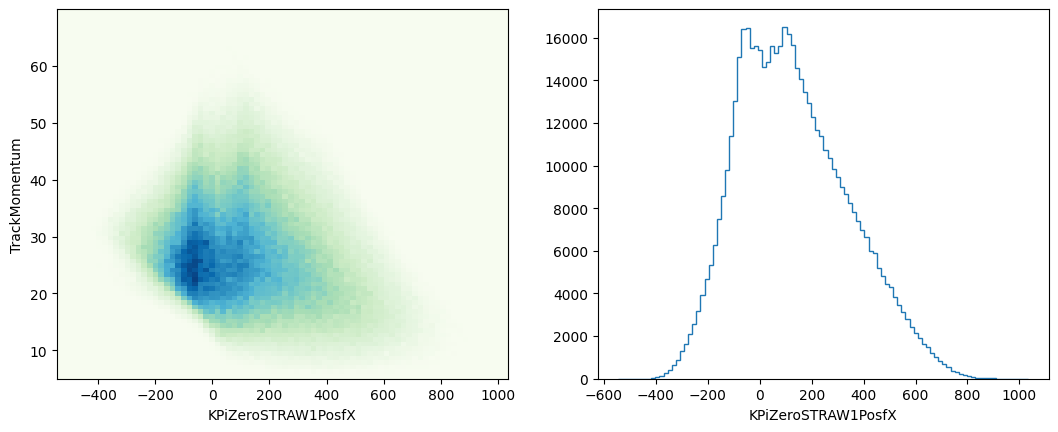

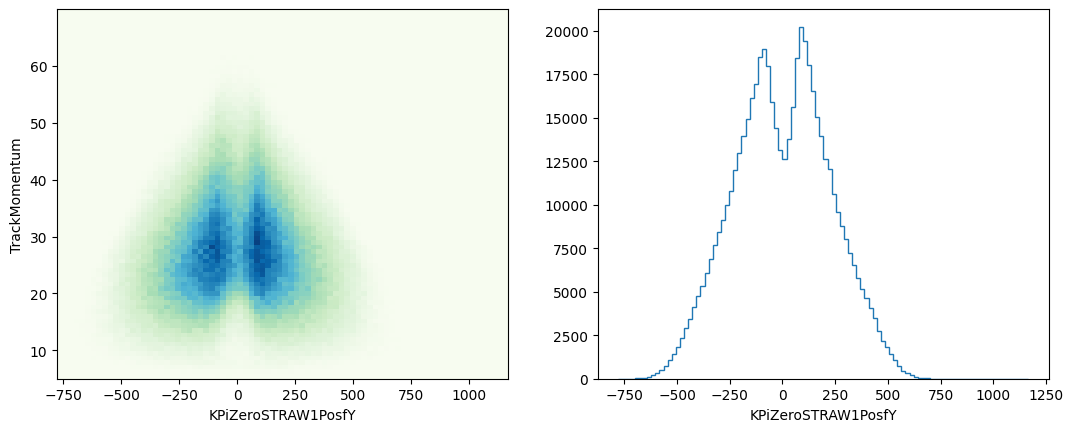

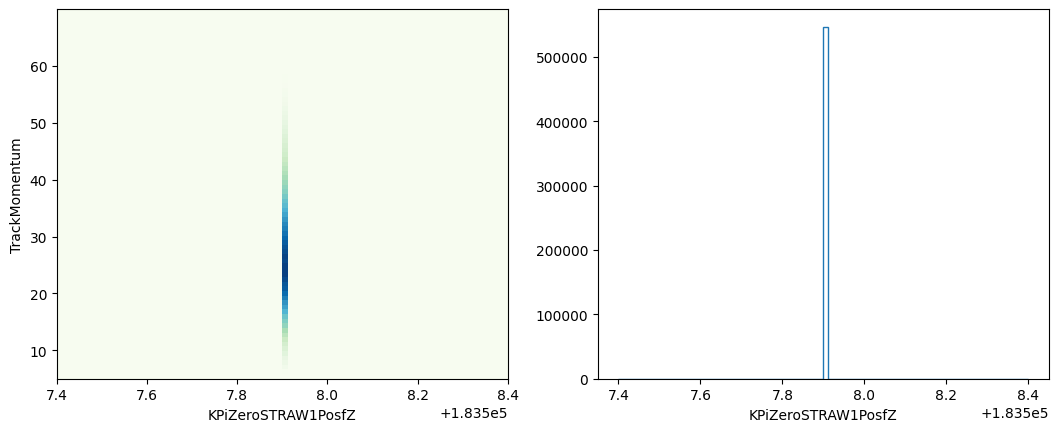

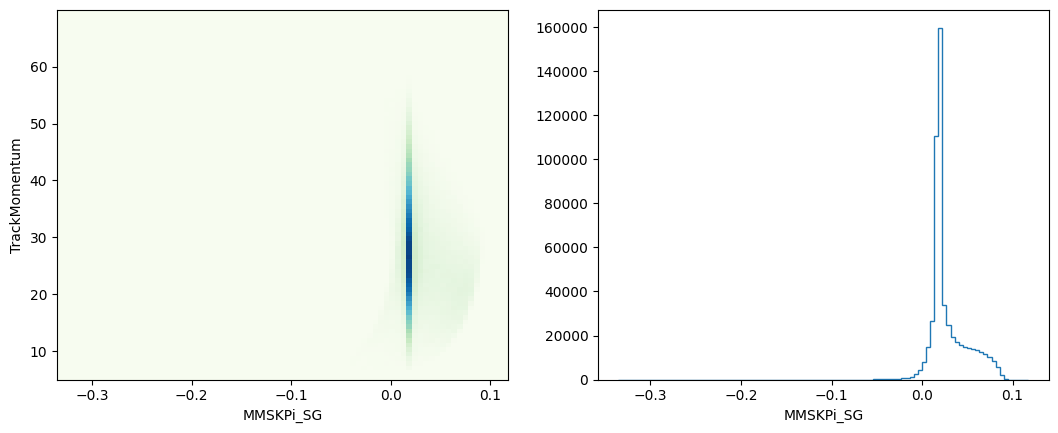

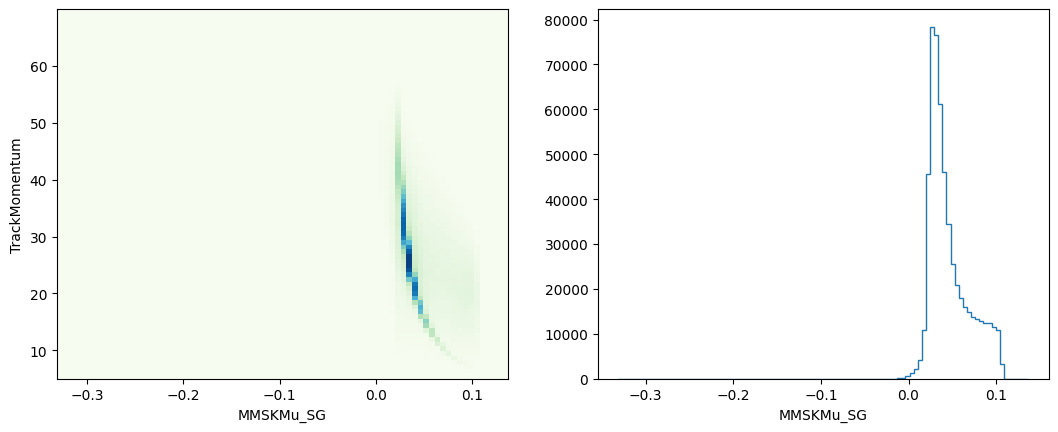

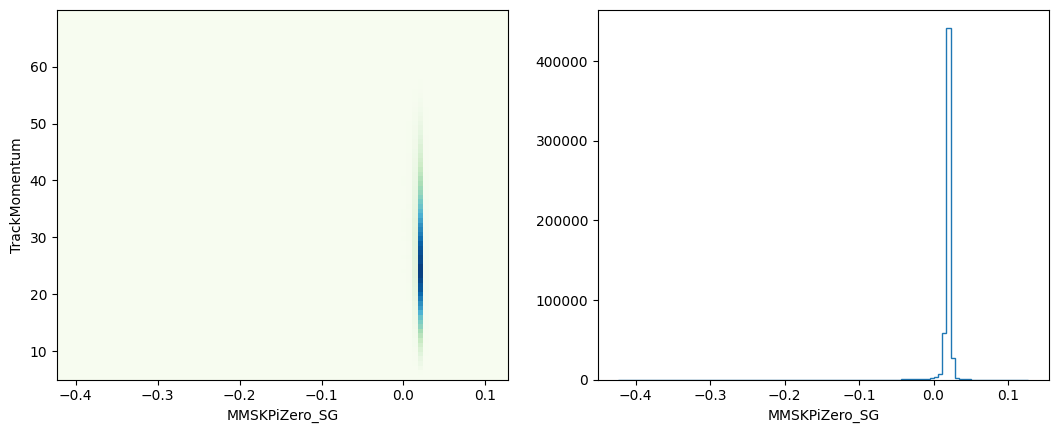

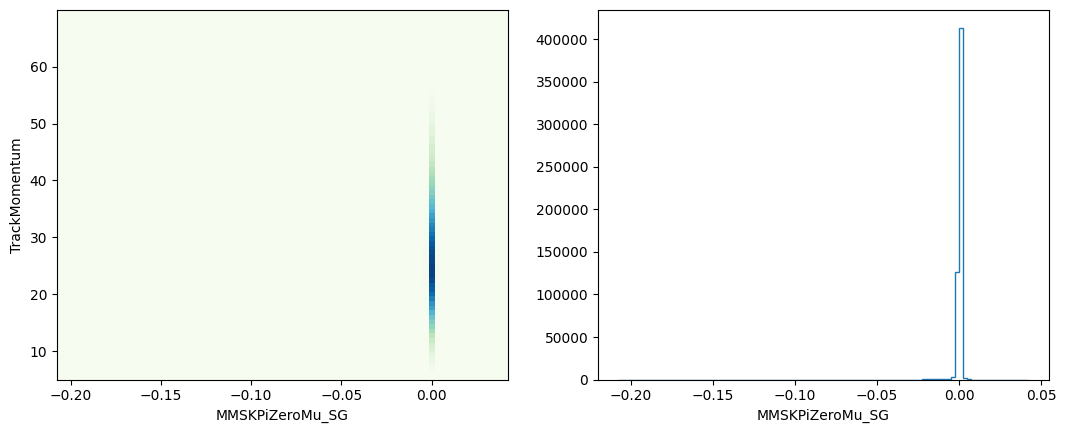

In [35]:
plot_list=['KPiZeroSTRAW1PosfX','KPiZeroSTRAW1PosfY','KPiZeroSTRAW1PosfZ','MMSKPi_SG','MMSKMu_SG','MMSKPiZero_SG','MMSKPiZeroMu_SG']

for key in plot_list:
    drawPlot_mms_vs_trkmom(key)

# Upstream (decay vertex < 185m) vs Downstream (decay vertex > 185m) PiMu Decay

In [36]:
#defining more variables (takes a few minutes to run)
df_1pi0region.loc[:,"DeltaMom_KPi_track"]=df_1pi0region.apply(lambda x: x['KPiZeroMomentum']-x['TrackMomentum'], axis=1)
df_1pi0region.loc[:,"DeltaDistSTRAW1_KPi_track"]=df_1pi0region.apply(lambda x: np.sqrt((x['KPiZeroSTRAW1PosfX']-x['TrackSTRAW1PosfX'])**2+(x['KPiZeroSTRAW1PosfY']-x['TrackSTRAW1PosfY'])**2), axis=1)
df_1pi0region.loc[:,"DeltaDistSTRAW2_KPi_track"]=df_1pi0region.apply(lambda x: np.sqrt((x['KPiZeroSTRAW2PosfX']-x['TrackSTRAW2PosfX'])**2+(x['KPiZeroSTRAW2PosfY']-x['TrackSTRAW2PosfY'])**2), axis=1)
df_1pi0region.loc[:,"DeltaDistSTRAW3_KPi_track"]=df_1pi0region.apply(lambda x: np.sqrt((x['KPiZeroSTRAW3PosfX']-x['TrackSTRAW3PosfX'])**2+(x['KPiZeroSTRAW3PosfY']-x['TrackSTRAW3PosfY'])**2), axis=1)
df_1pi0region.loc[:,"DeltaDistSTRAW4_KPi_track"]=df_1pi0region.apply(lambda x: np.sqrt((x['KPiZeroSTRAW4PosfX']-x['TrackSTRAW4PosfX'])**2+(x['KPiZeroSTRAW4PosfY']-x['TrackSTRAW4PosfY'])**2), axis=1)
df_1pi0region.loc[:,"DeltaMom_trackFit"]=df_1pi0region.apply(lambda x: x['TrackMomentum']-x['TrackMomentumBeforeFit'], axis=1)
df_1pi0region.loc[:,"DeltaSlopeX_trackFit_BeforeMagnet"]=df_1pi0region.apply(lambda x: x['TrackSlopeXBeforeMagnet']-x['TrackSlopeXBeforeFit'], axis=1)
df_1pi0region.loc[:,"DeltaSlopeY_trackFit_BeforeMagnet"]=df_1pi0region.apply(lambda x: x['TrackSlopeYBeforeMagnet']-x['TrackSlopeYBeforeFit'], axis=1)
df_1pi0region.loc[:,"DeltaSlopeX_trackFit_AfterMagnet"]=df_1pi0region.apply(lambda x: x['TrackSlopeXAfterMagnet']-x['TrackSlopeXBeforeFit'], axis=1)
df_1pi0region.loc[:,"DeltaSlopeY_trackFit_AfterMagnet"]=df_1pi0region.apply(lambda x: x['TrackSlopeYAfterMagnet']-x['TrackSlopeYBeforeFit'], axis=1)

#defining the upstream and downstream decay group of data
df_1pi0region.loc[:,"up_vs_downstream"]=df_1pi0region.apply(lambda x: "upstream" if x['PiChDecayZvertex']<185000 and x['PiChDecayZvertex']!=1 else "downstream", axis=1)
df_1pi0region.loc[:,"up_vs_downstream_int"]=df_1pi0region.apply(lambda x: 1 if x['PiChDecayZvertex']<185000 and x['PiChDecayZvertex']!=1 else 0, axis=1)
df_upstream=df_1pi0region.loc[df_1pi0region['up_vs_downstream']=="upstream"]
df_downstream=df_1pi0region.loc[df_1pi0region['up_vs_downstream']=="downstream"]

In [37]:
def drawPlot_up_vs_downstream(key,rmin=None,rmax=None):
    if(rmin!=None and rmax!=None):
        df_1pi0region_reduced=df_1pi0region.loc[(df_1pi0region[key]>rmin) & (df_1pi0region[key]<rmax)]
        df_upstream_reduced=df_upstream.loc[(df_upstream[key]>rmin) & (df_upstream[key]<rmax)]
        df_downstream_reduced=df_downstream.loc[(df_downstream[key]>rmin) & (df_downstream[key]<rmax)]
    elif(rmin!=None):
        df_1pi0region_reduced=df_1pi0region.loc[df_1pi0region[key]>rmin]
        df_upstream_reduced=df_upstream.loc[df_upstream[key]>rmin]
        df_downstream_reduced=df_downstream.loc[df_downstream[key]>rmin]
    elif(rmax!=None):
        df_1pi0region_reduced=df_1pi0region.loc[df_1pi0region[key]<rmax]
        df_upstream_reduced=df_upstream.loc[df_upstream[key]<rmax]
        df_downstream_reduced=df_downstream.loc[df_downstream[key]<rmax]
    else:
        df_1pi0region_reduced=df_1pi0region
        df_upstream_reduced=df_upstream
        df_downstream_reduced=df_downstream
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

    ax1.hist2d(df_1pi0region_reduced["PiChDecayZvertex"], df_1pi0region_reduced[key], bins=80, cmap='GnBu')
    ax1.set_xlabel("PiChDecayZvertex")
    ax1.set_ylabel(key)
    ymin=ax1.get_ylim()[0]
    ymax=ax1.get_ylim()[1]
    ax1.vlines(STRAW1Z, ymin, ymax, 'r', '--', lw=1)
    ax1.vlines(STRAW2Z, ymin, ymax, 'r', '--', lw=1)
    ax1.vlines(STRAW3Z, ymin, ymax, 'r', '--', lw=1)
    ax1.vlines(STRAW4Z, ymin, ymax, 'r', '--', lw=1)
    ax1.vlines(MNP33Z, ymin, ymax, 'm', '--', lw=1)
               
    ax2.hist(df_upstream_reduced[key],bins=100,histtype='step')
    ax2.hist(df_downstream_reduced[key],bins=100,histtype='step')
    ax2.set_xlabel(key)
    
    ax2.legend(['upstream decay (<185m)', 'downstream decay (>185m)'])
    plt.show();
    fig.savefig("plot_downstream_pimuDecay_suppression_study/upstream_vs_downstreamPiMudecay_{}.pdf".format(key))

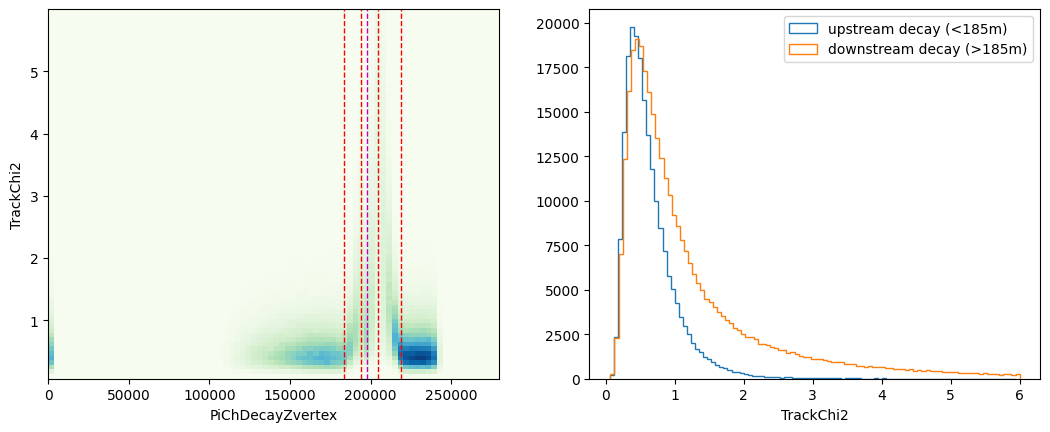

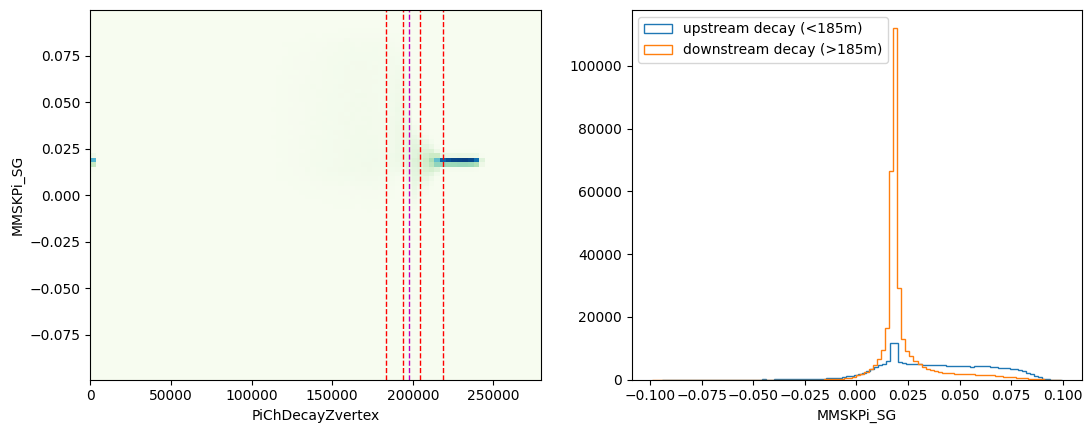

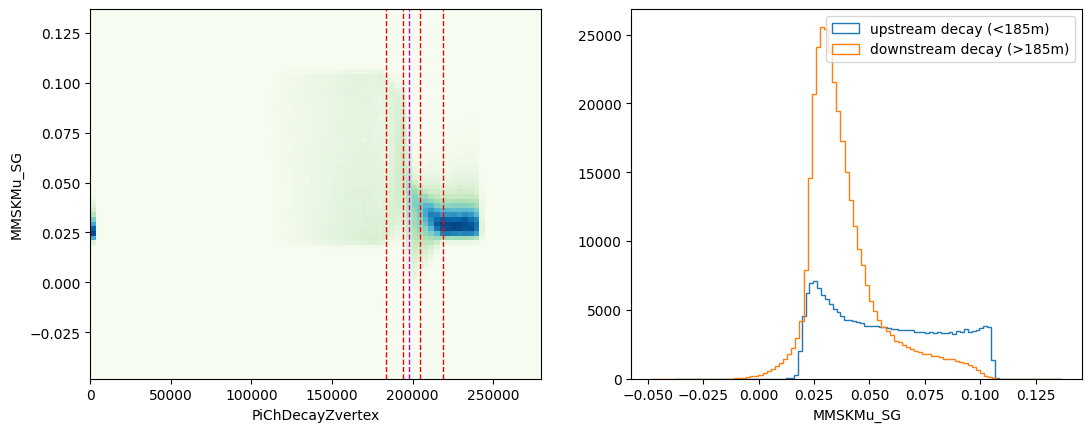

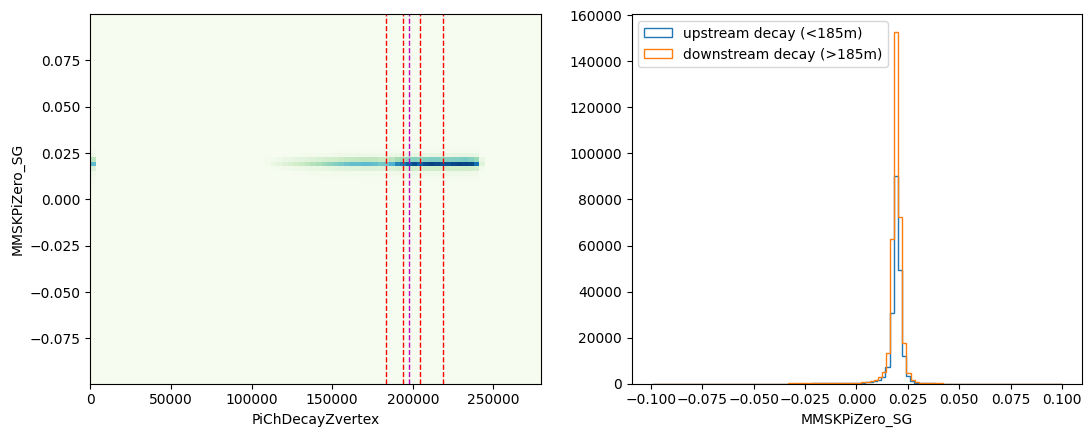

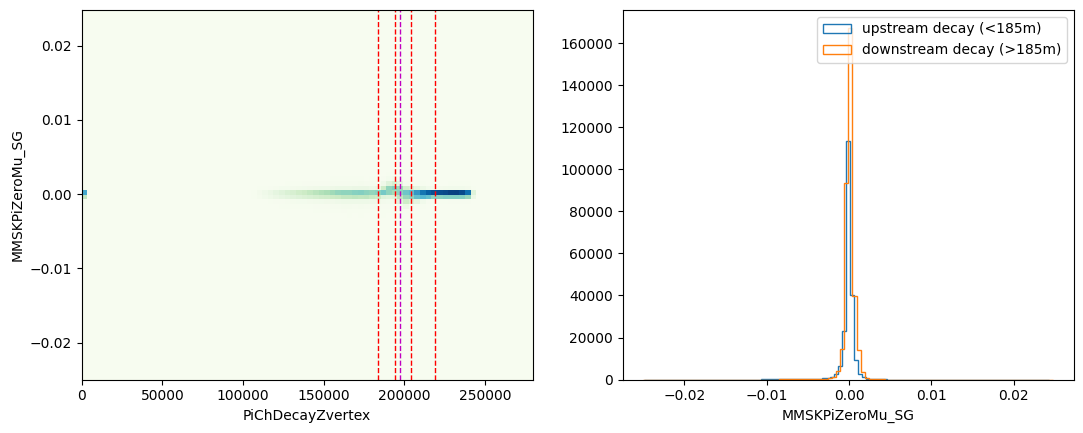

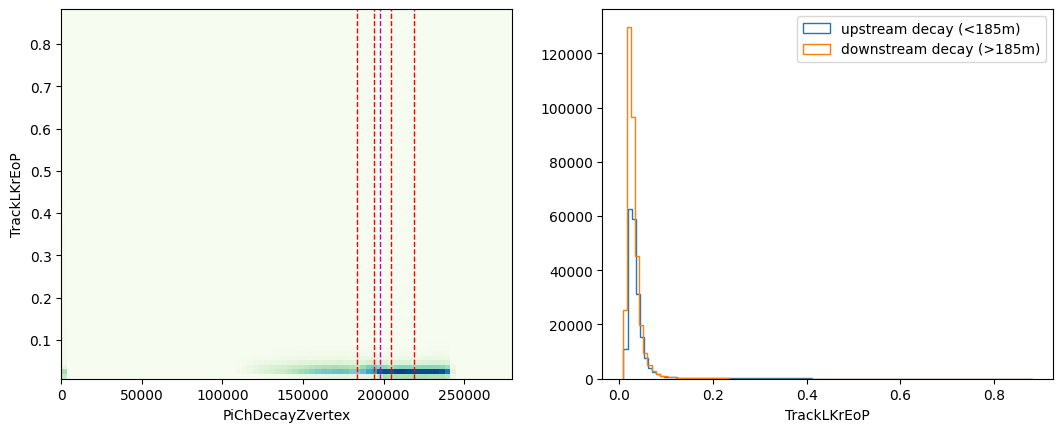

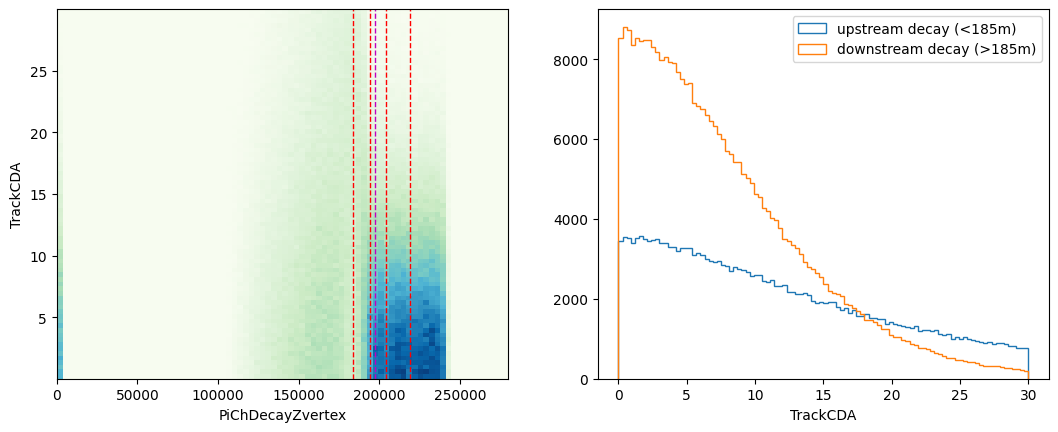

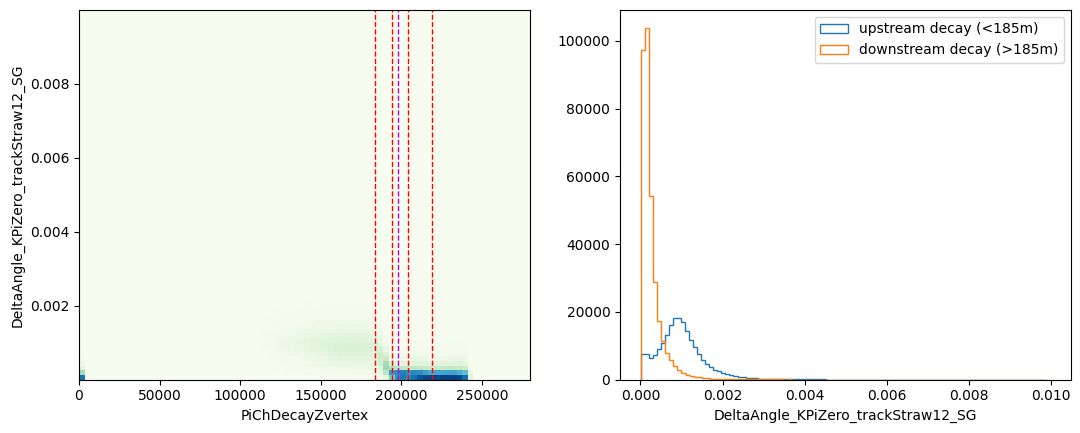

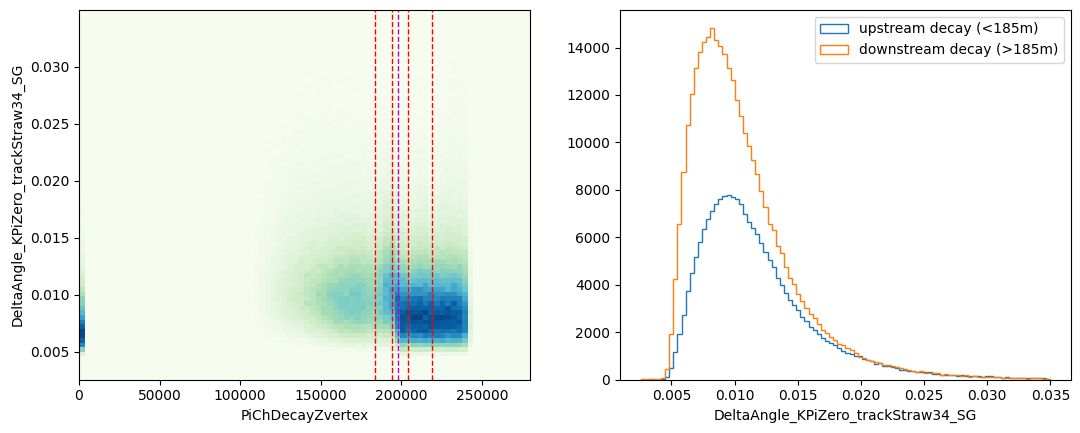

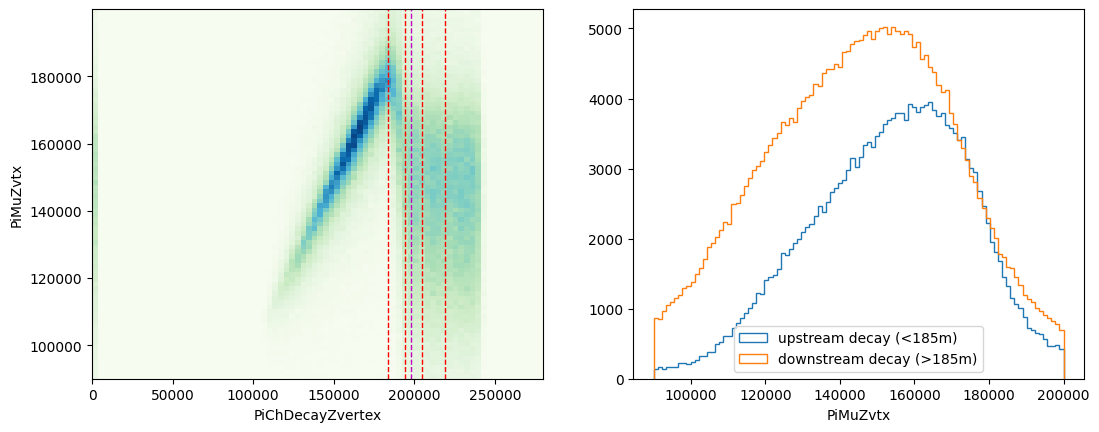

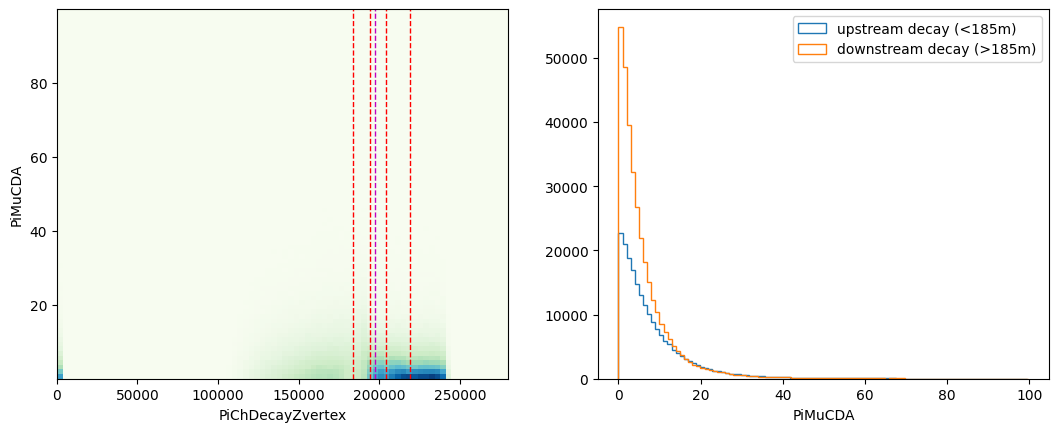

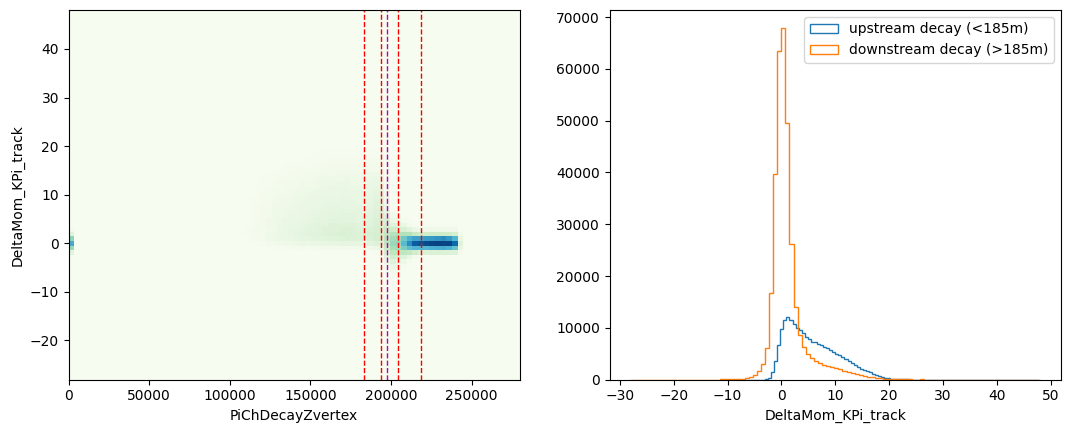

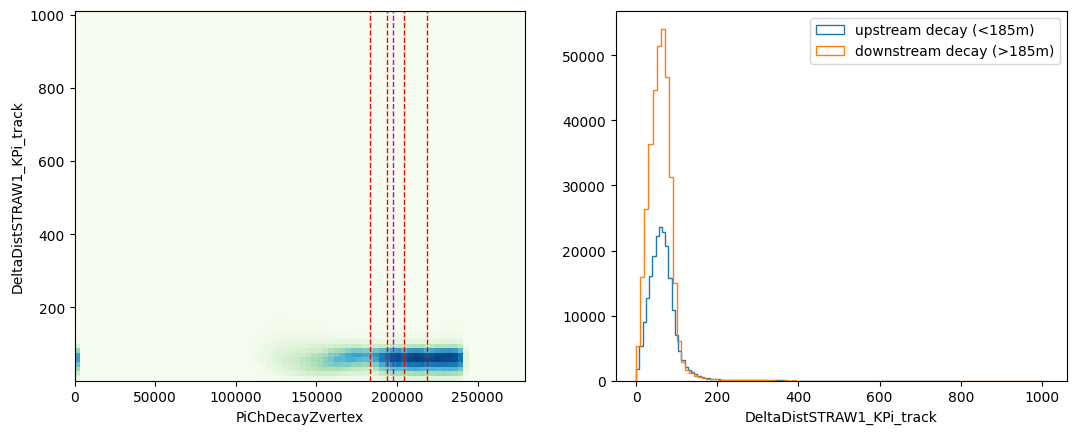

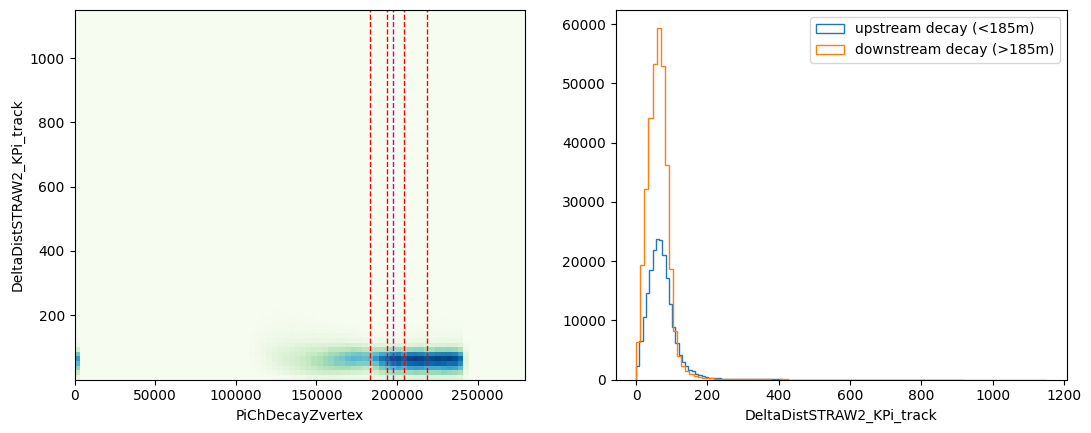

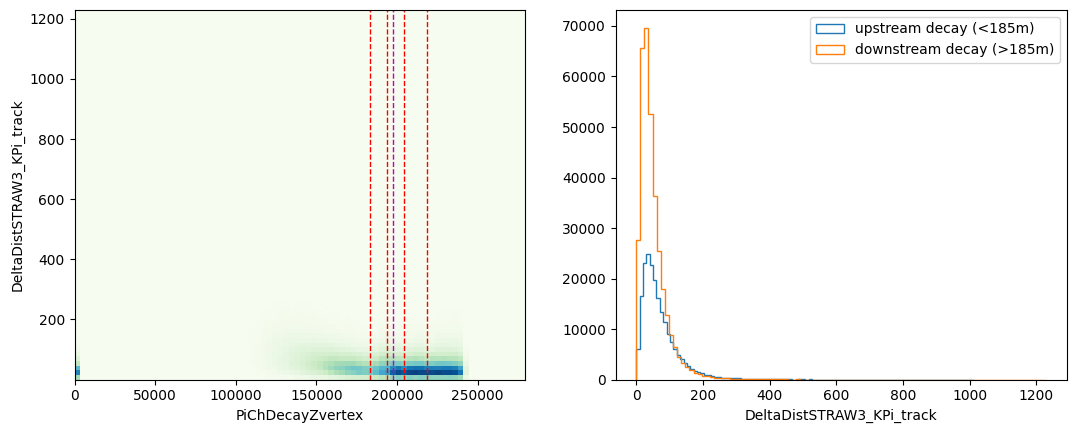

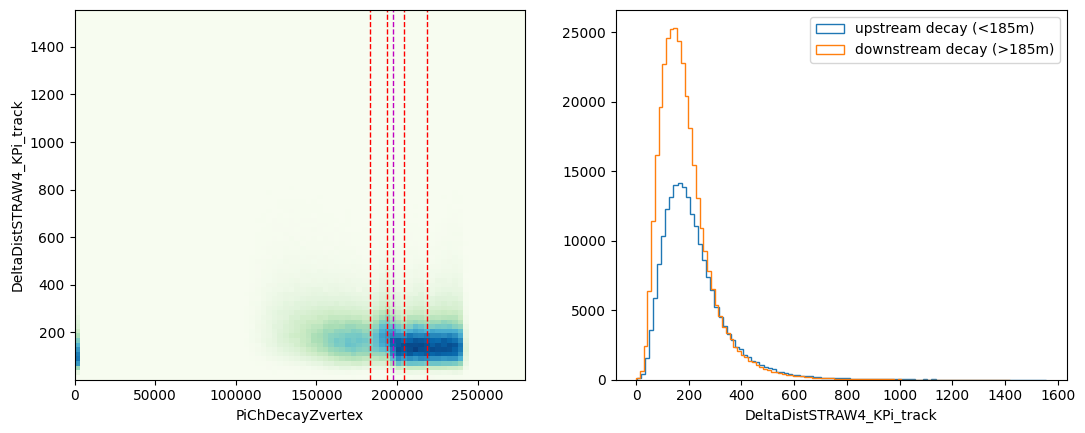

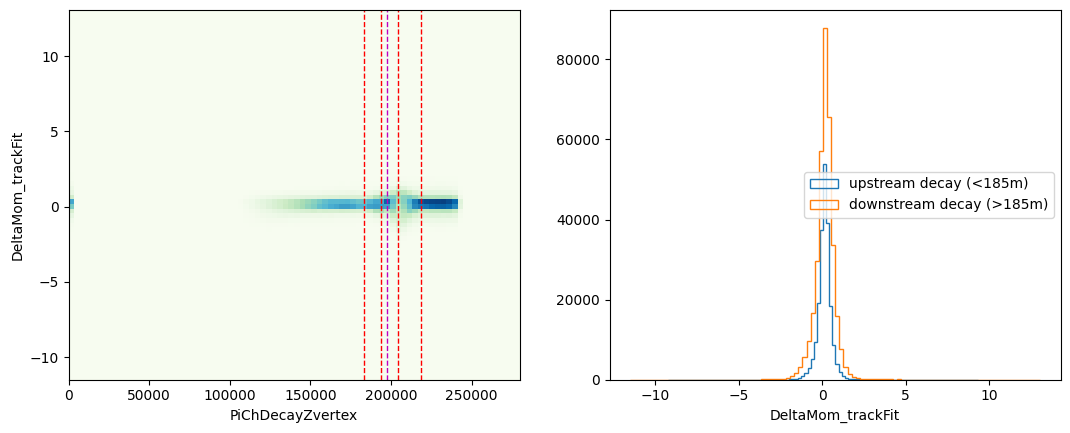

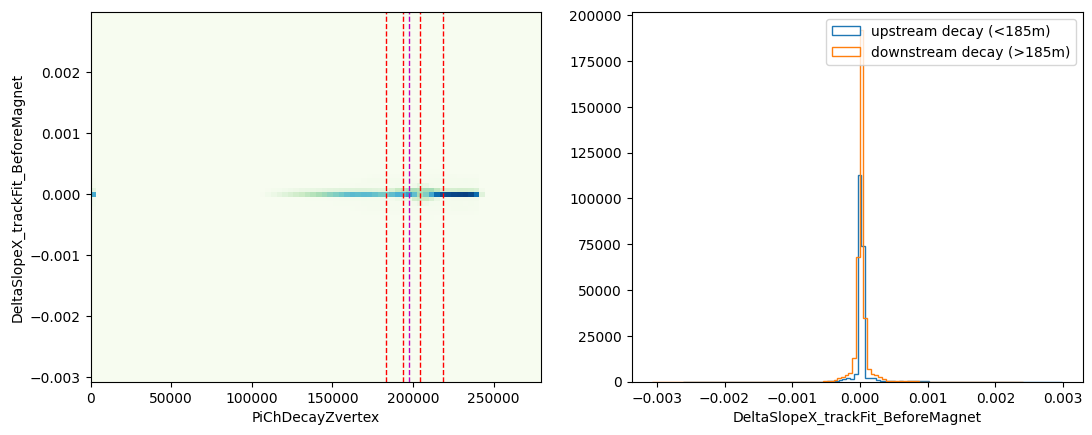

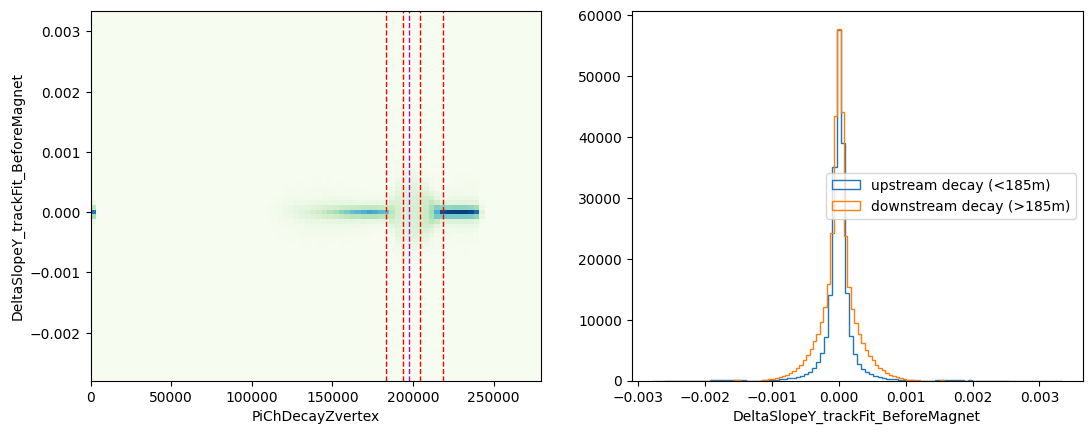

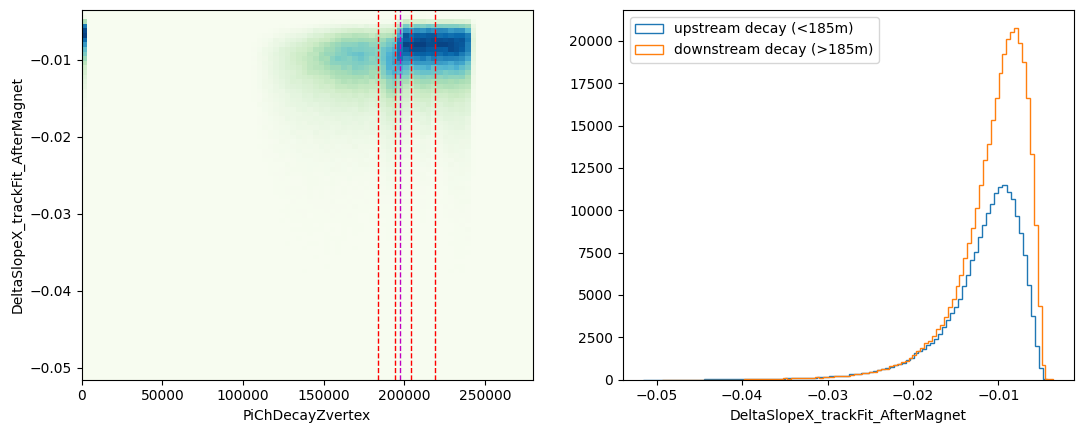

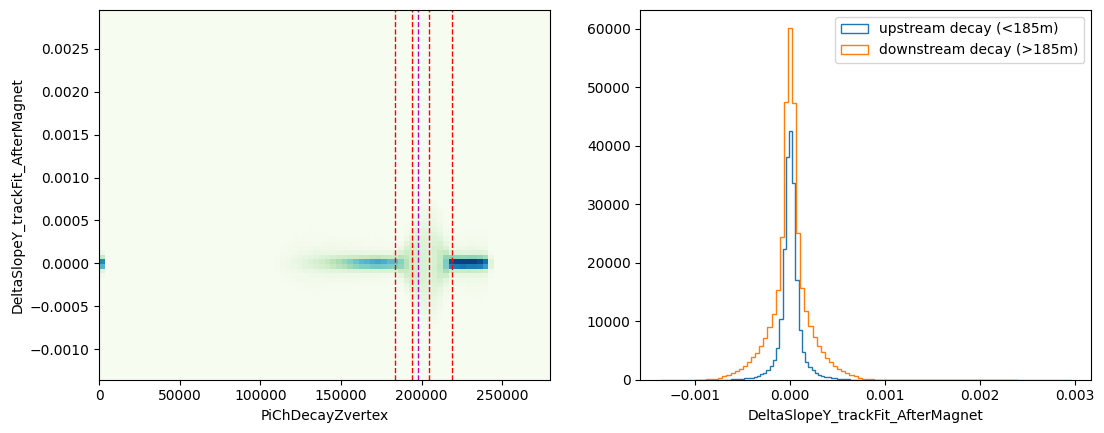

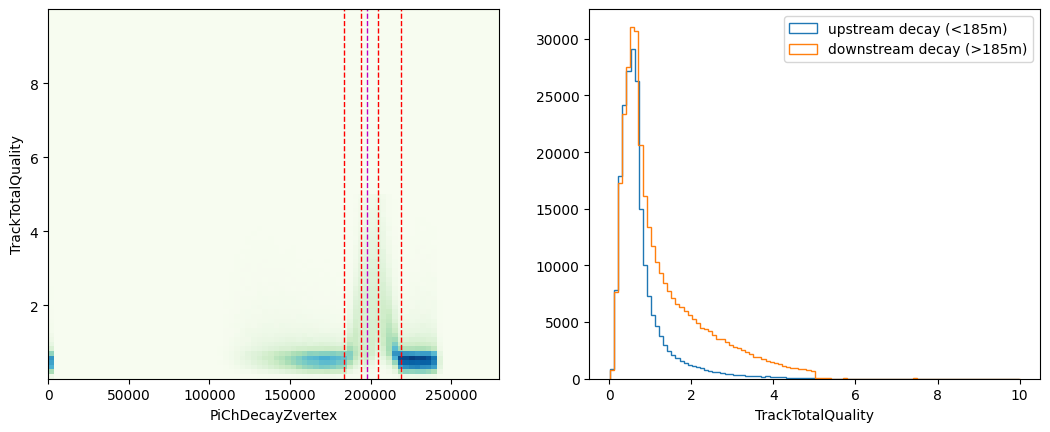

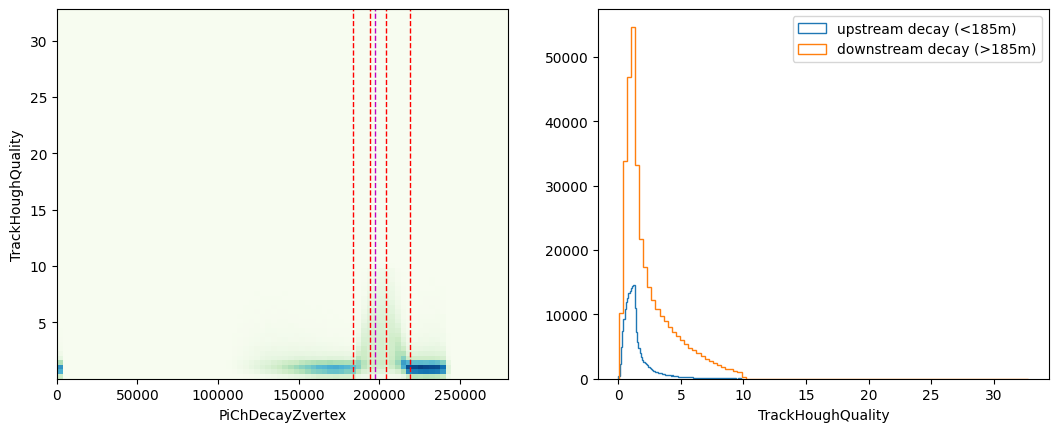

In [38]:
plot_list=['TrackChi2','MMSKPi_SG','MMSKMu_SG','MMSKPiZero_SG','MMSKPiZeroMu_SG',
           'TrackLKrEoP','TrackCDA','DeltaAngle_KPiZero_trackStraw12_SG','DeltaAngle_KPiZero_trackStraw34_SG',
           'PiMuZvtx','PiMuCDA','DeltaMom_KPi_track',
           'DeltaDistSTRAW1_KPi_track','DeltaDistSTRAW2_KPi_track',
           'DeltaDistSTRAW3_KPi_track','DeltaDistSTRAW4_KPi_track',
           'DeltaMom_trackFit','DeltaSlopeX_trackFit_BeforeMagnet','DeltaSlopeY_trackFit_BeforeMagnet',
           'DeltaSlopeX_trackFit_AfterMagnet','DeltaSlopeY_trackFit_AfterMagnet',
           'TrackTotalQuality','TrackHoughQuality']

rrange={
    'TrackChi2': [0,6],
    'MMSKPi_SG': [-0.1,0.1],
    'MMSKMu_SG': [-0.05,0.15],
    'MMSKPiZero_SG': [-0.1,0.1],
    'MMSKPiZeroMu_SG': [-0.025,0.025],
    'TrackLKrEoP': [None,None],
    'TrackCDA': [None,None],
    'DeltaAngle_KPiZero_trackStraw12_SG': [0,0.01],
    'DeltaAngle_KPiZero_trackStraw34_SG': [0.0025,0.035],
    'PiMuZvtx': [90000,200000],
    'PiMuCDA': [0,100],
    'DeltaMom_KPi_track': [None,None],
    'DeltaDistSTRAW1_KPi_track': [None,None],
    'DeltaDistSTRAW2_KPi_track': [None,None],
    'DeltaDistSTRAW3_KPi_track': [None,None],
    'DeltaDistSTRAW4_KPi_track': [None,None],
    'TrackTotalQuality': [0,10]
}

for key in plot_list:
    if(key in rrange):
        drawPlot_up_vs_downstream(key,rmin=rrange[key][0],rmax=rrange[key][1])
    else:
        drawPlot_up_vs_downstream(key)

Correlation heatmap for upstream events:


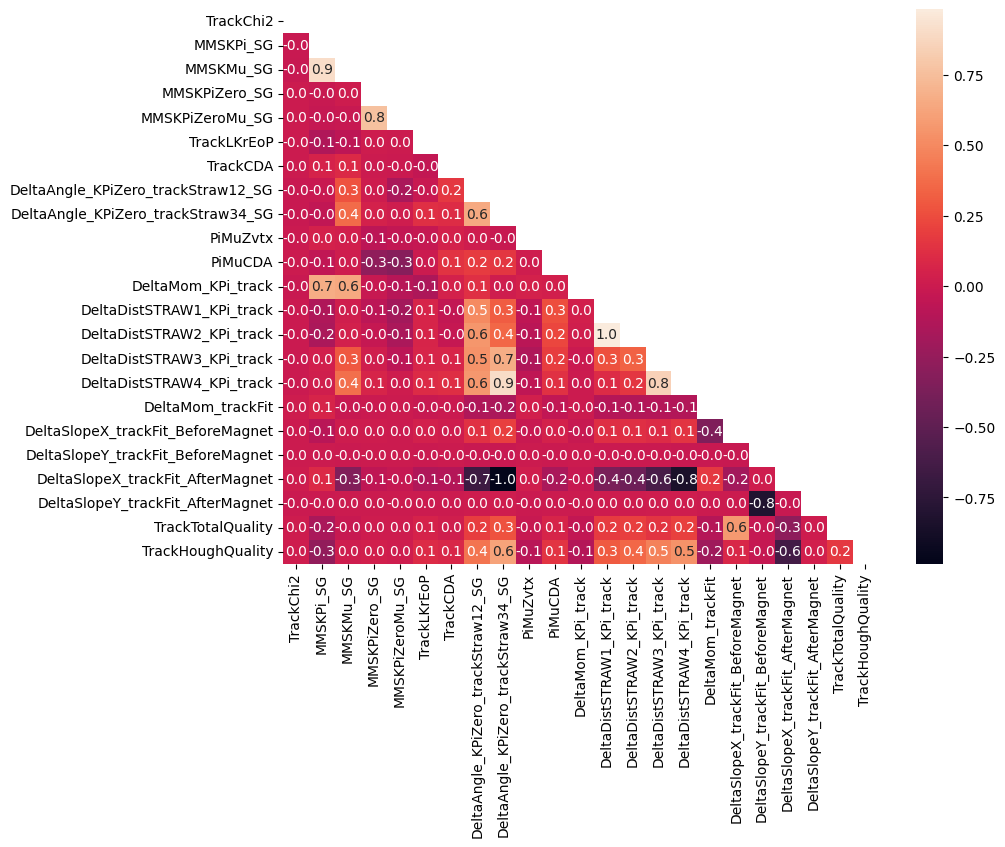

Correlation heatmap for downstream events:


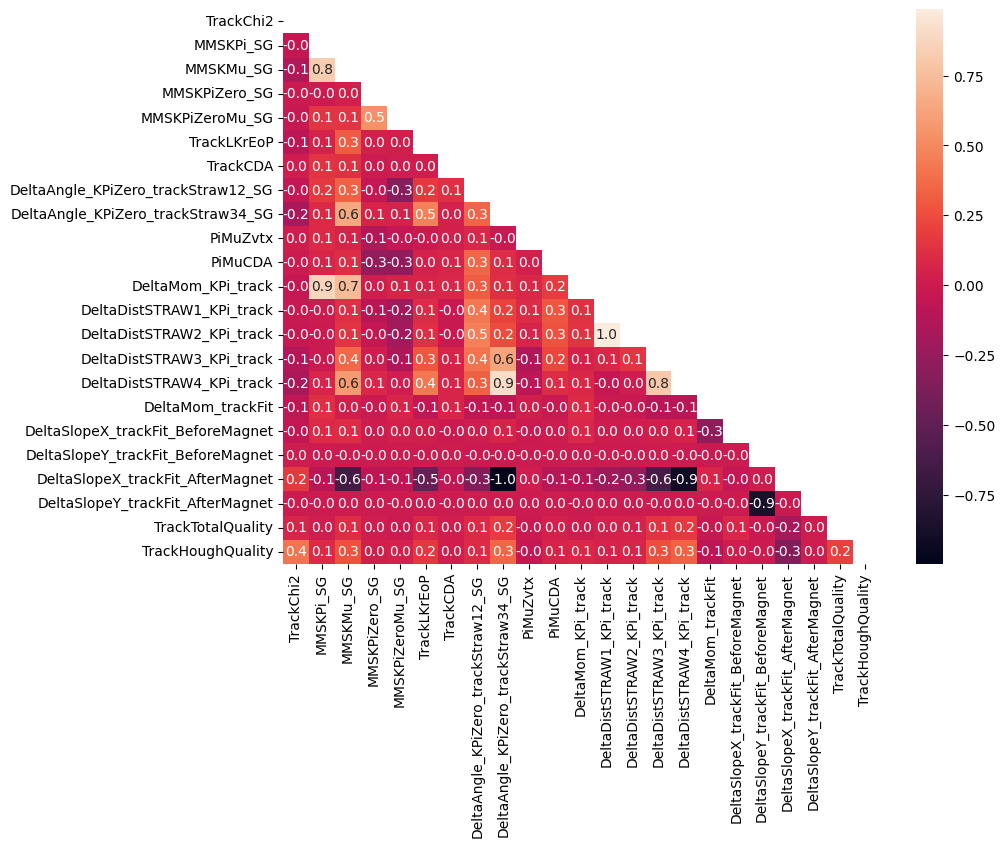

In [39]:
# Computing correlation among the list of interesting variables above
corr_upstream=df_upstream[plot_list].corr()
corr_downstream=df_downstream[plot_list].corr()

# Extract the list of variable where high correlation is observed 
# (so sns.pairplot can run faster on smaller set of variables)
highcorr_list=[]
for var1 in plot_list:
    for var2 in plot_list:
        if(var1!=var2 and (np.abs(corr_upstream.loc[var1,var2])>0.80 or np.abs(corr_downstream.loc[var1,var2])>0.80)):
            if(var1 not in highcorr_list):
                highcorr_list.append(var1)
            if(var2 not in highcorr_list):
                highcorr_list.append(var2)

#plotting correlation heatmap for upstream events
print("Correlation heatmap for upstream events:")
fig, ax = plt.subplots(1, figsize=(9.6, 7.2))
sns.heatmap(corr_upstream, 
            xticklabels=corr_upstream.columns,
            yticklabels=corr_upstream.columns,
            annot=True, fmt=".1f",mask=np.triu(corr_upstream))
plt.show()

#plotting correlation heatmap for downstream events
print("Correlation heatmap for downstream events:")
fig, ax = plt.subplots(1, figsize=(9.6, 7.2))
sns.heatmap(corr_downstream, 
            xticklabels=corr_downstream.columns,
            yticklabels=corr_downstream.columns,
            annot=True, fmt=".1f",mask=np.triu(corr_downstream))

plt.show()


High correlation list:  ['MMSKPi_SG', 'MMSKMu_SG', 'DeltaMom_KPi_track', 'DeltaAngle_KPiZero_trackStraw34_SG', 'DeltaDistSTRAW4_KPi_track', 'DeltaSlopeX_trackFit_AfterMagnet', 'DeltaDistSTRAW1_KPi_track', 'DeltaDistSTRAW2_KPi_track', 'DeltaDistSTRAW3_KPi_track', 'DeltaSlopeY_trackFit_BeforeMagnet', 'DeltaSlopeY_trackFit_AfterMagnet']
Scatterplot for variables with high correlation (upstream events):


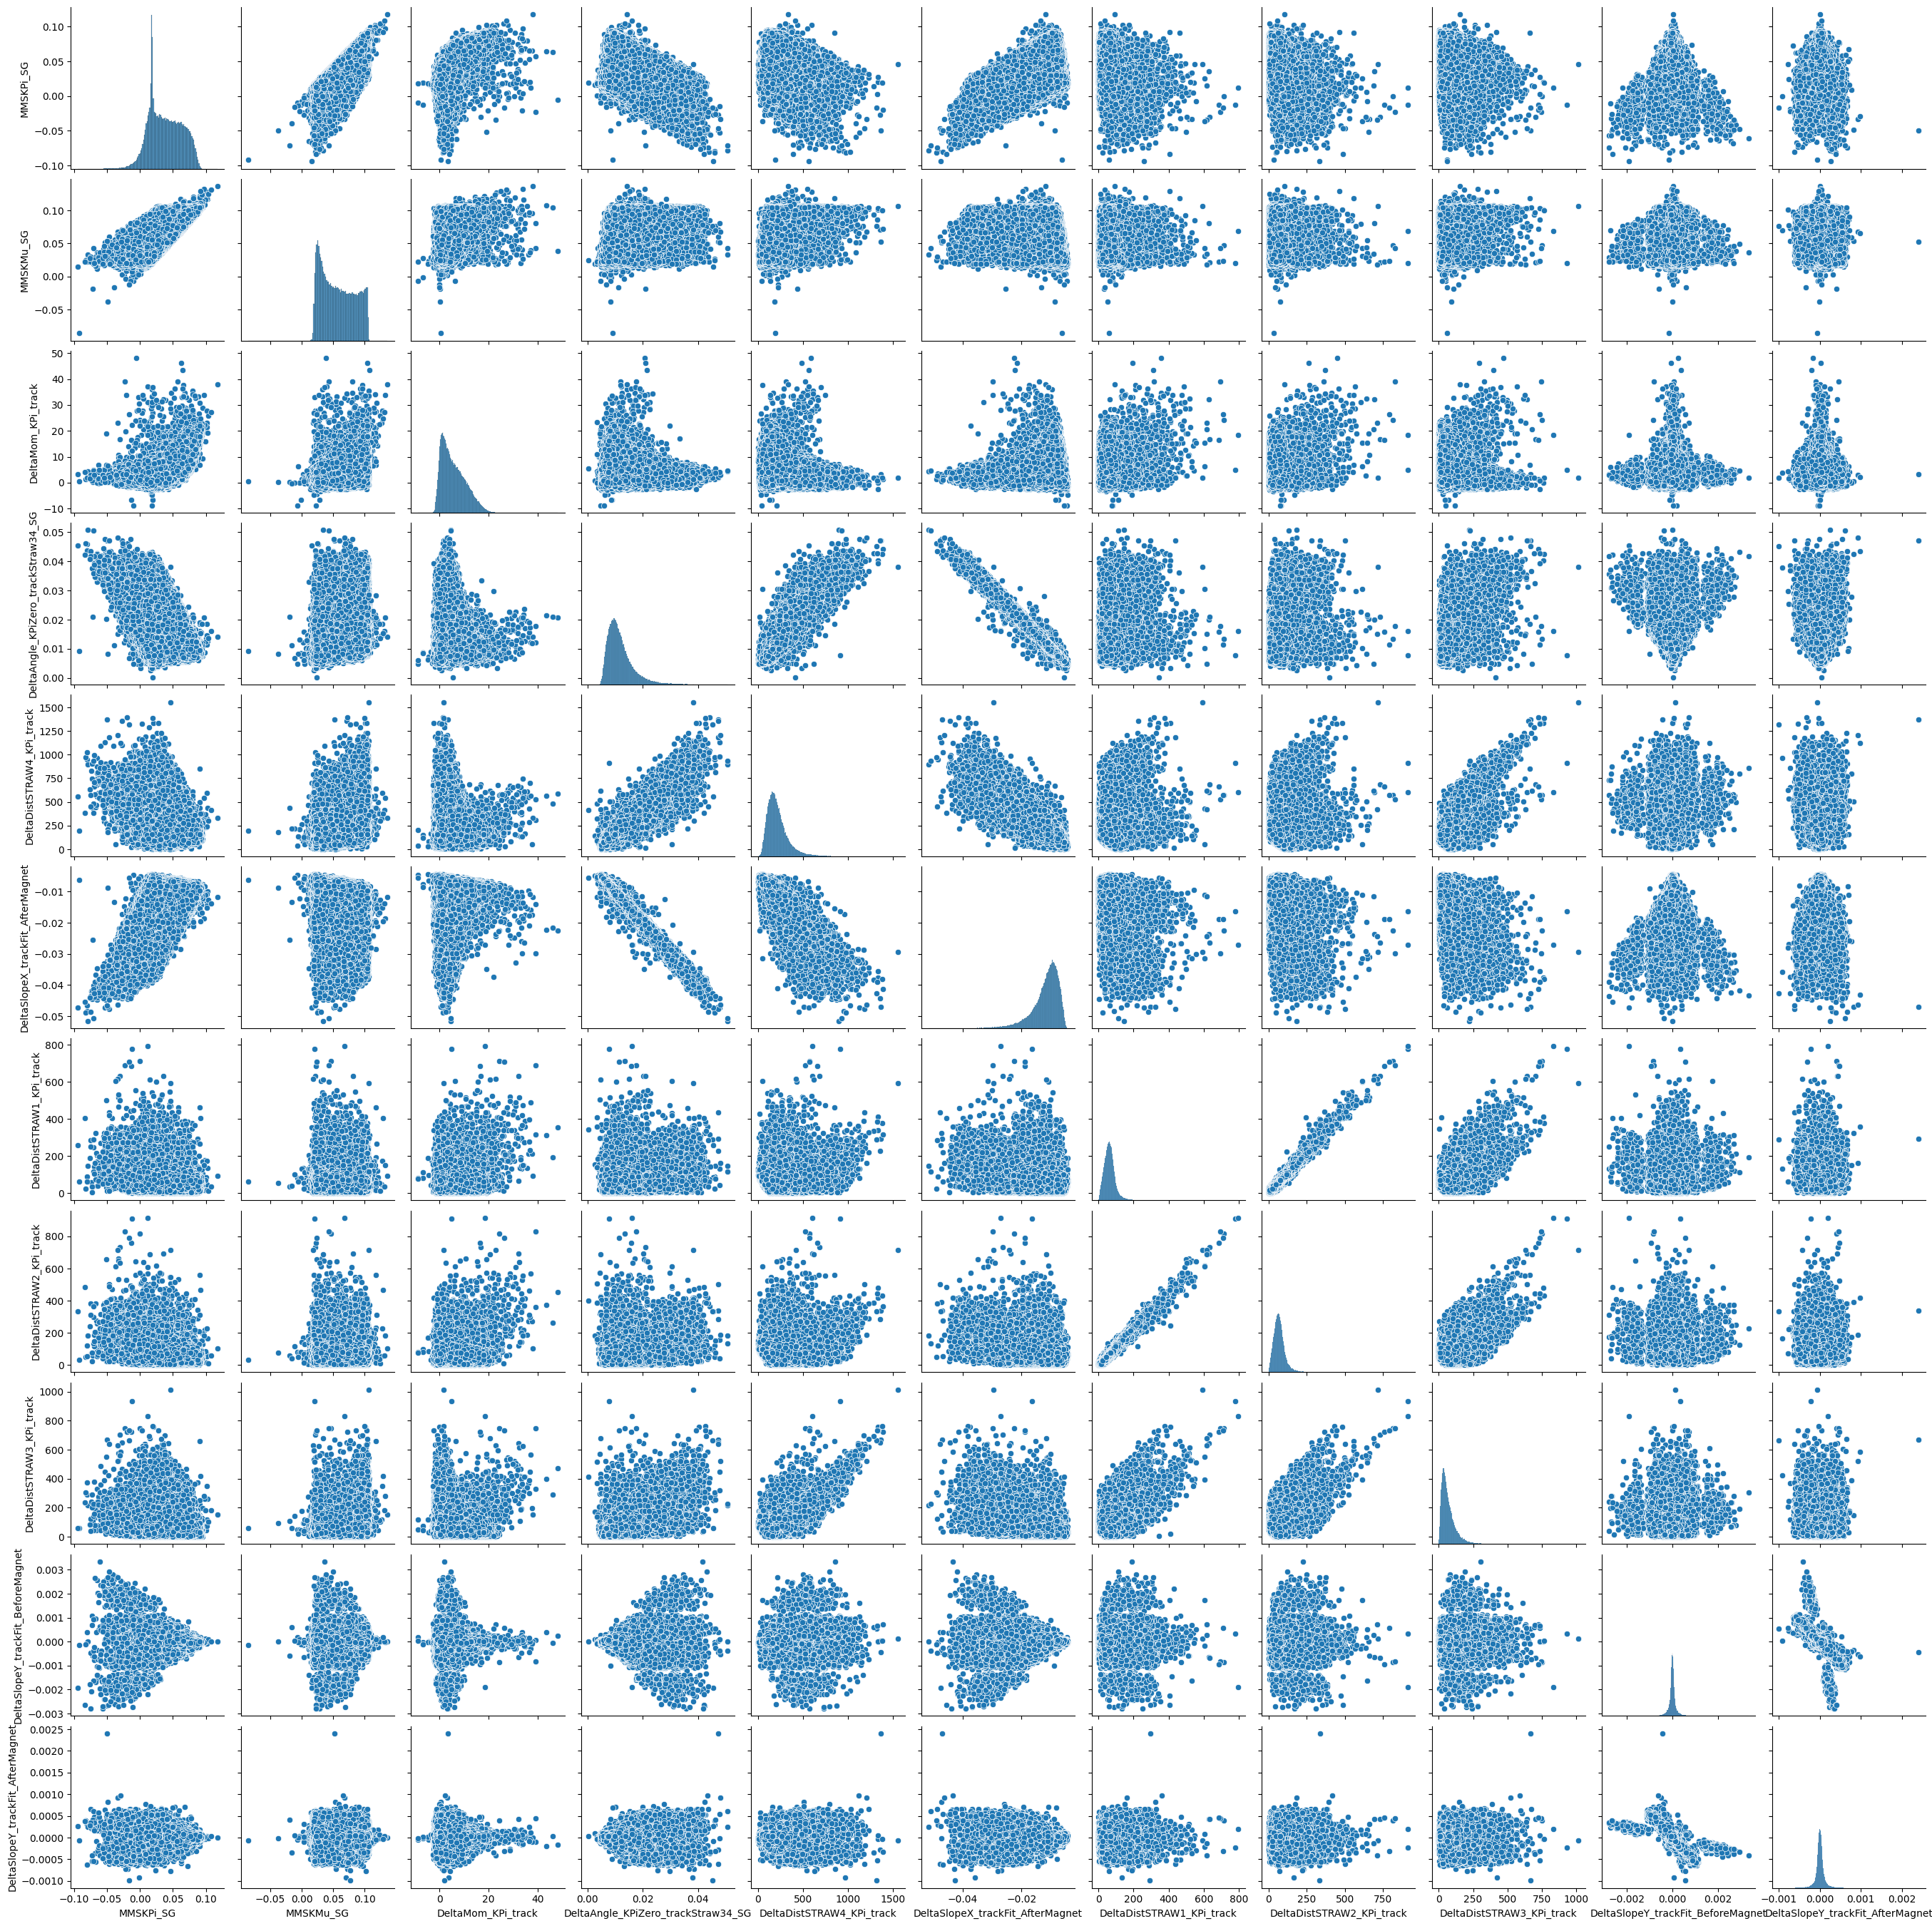

Scatterplot for variables with high correlation (downstream events):


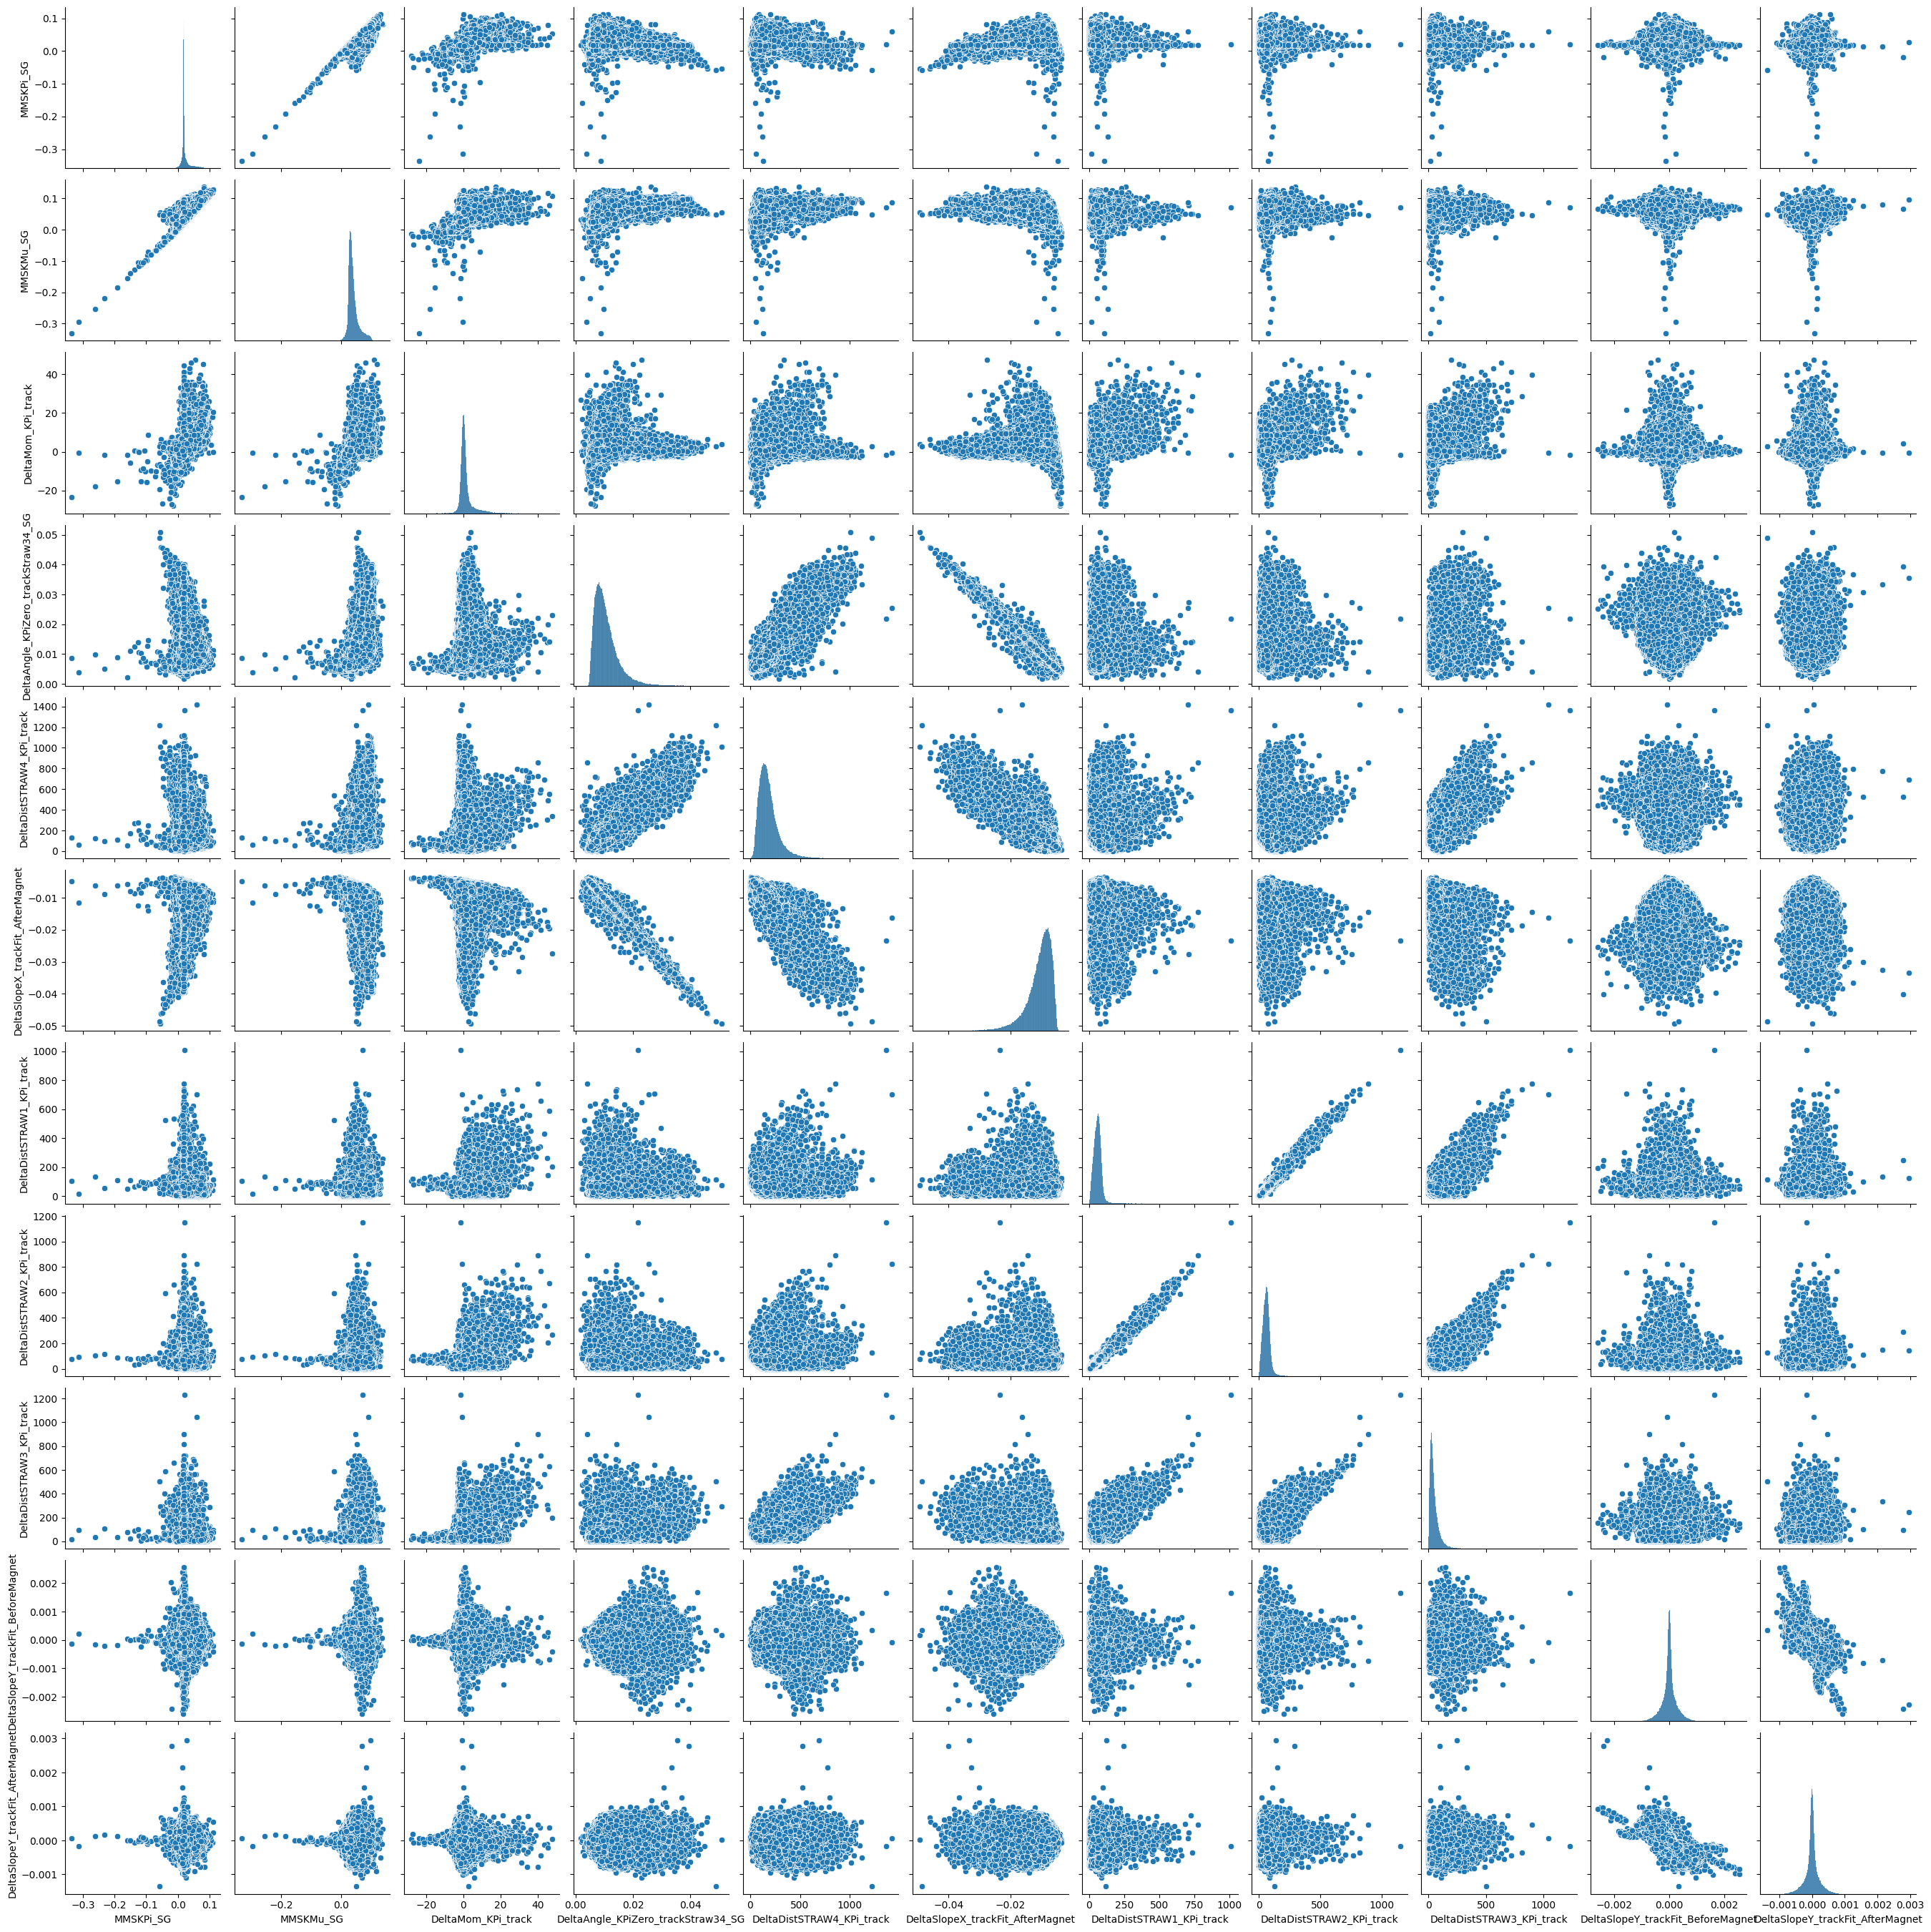

In [40]:
#Plots take a few minutes to run. First check high correlation list.
print("High correlation list: ", highcorr_list)

#Plot pairplot for upstream events
print("Scatterplot for variables with high correlation (upstream events):")
sns.pairplot(df_upstream[highcorr_list])
plt.show()

#Plot pairplot for downstream events
print("Scatterplot for variables with high correlation (downstream events):")
sns.pairplot(df_downstream[highcorr_list])
plt.show()

# Cut-based suppression of downstream PiMu decay

In [41]:
print("The S/sqrt(S+B) ratio before cuts = {:.2f}".format(len(df_upstream)/np.sqrt(len(df_upstream)+len(df_downstream))))

df_1pi0region_selected=df_1pi0region.loc[(df_1pi0region['TrackChi2']<1.5)
                                         & (df_1pi0region['MMSKPi_SG']>0.025) 
                                         & (df_1pi0region['DeltaAngle_KPiZero_trackStraw12_SG']>0.0005)]
df_upstream_selected=df_1pi0region_selected.loc[df_1pi0region['up_vs_downstream']=="upstream"]
df_downstream_selected=df_1pi0region_selected.loc[df_1pi0region['up_vs_downstream']=="downstream"]

s_over_sqrtsb=len(df_upstream_selected)/np.sqrt(len(df_upstream_selected)+len(df_downstream_selected))
benchmark=[1.*len(df_upstream_selected)/len(df_upstream), 1.*len(df_downstream)/len(df_downstream_selected)]
print("The S/sqrt(S+B) ratio after cuts = {:.2f}".format(s_over_sqrtsb))
print("  Efficiency of upstream decay events = {:.2f}%".format(100.*benchmark[0]))
print("  Efficiency of downstream decay events = {:.2f}%".format(100./benchmark[1]))

The S/sqrt(S+B) ratio before cuts = 277.01
The S/sqrt(S+B) ratio after cuts = 319.82
  Efficiency of upstream decay events = 55.69%
  Efficiency of downstream decay events = 3.85%


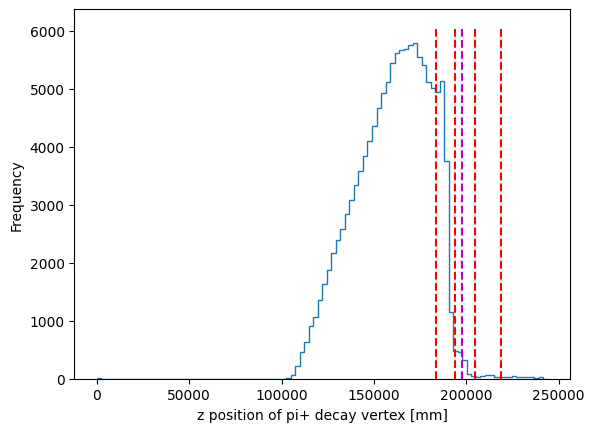

In [42]:
ax=df_1pi0region_selected['PiChDecayZvertex'].plot.hist(bins=100,histtype='step')
ax.set_xlabel("z position of pi+ decay vertex [mm]")
ymin=ax.get_ylim()[0]
ymax=ax.get_ylim()[1]
plt.vlines(STRAW1Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW2Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW3Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW4Z, ymin, ymax, 'r', '--')
plt.vlines(MNP33Z, ymin, ymax, 'm', '--')
plt.show();
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/pimudecayZvtx_cutbased.pdf")

# BDT classification of upstream vs downstream PiMu decay
Two setups to try:

* Train with all of the above discriminating variables
* Train with all except TrackChi2, which is poorly modelled

## Configuring BDT setup (dataset, cross-validation, training pipeline)

In [43]:
# Dataset configurations
label_var="up_vs_downstream_int" # 1 means upstream; 0 means downstream

input_mode="NoTrackChi2"
if(input_mode=="NoTrackChi2"):
    input_var=['MMSKPi_SG','MMSKMu_SG','MMSKPiZero_SG','MMSKPiZeroMu_SG',
           'TrackLKrEoP','TrackCDA','DeltaAngle_KPiZero_trackStraw12_SG','DeltaAngle_KPiZero_trackStraw34_SG',
           'PiMuZvtx','PiMuCDA','DeltaMom_KPi_track',
           'DeltaDistSTRAW1_KPi_track','DeltaDistSTRAW2_KPi_track',
           'DeltaDistSTRAW3_KPi_track','DeltaDistSTRAW4_KPi_track']
elif(input_mode=="NoMMSKPiZero_NoMMSKPiZeroMu"):
    input_var=['TrackChi2','MMSKPi_SG','MMSKMu_SG',
           'TrackLKrEoP','TrackCDA','DeltaAngle_KPiZero_trackStraw12_SG','DeltaAngle_KPiZero_trackStraw34_SG',
           'PiMuZvtx','PiMuCDA','DeltaMom_KPi_track',
           'DeltaDistSTRAW1_KPi_track','DeltaDistSTRAW2_KPi_track',
           'DeltaDistSTRAW3_KPi_track','DeltaDistSTRAW4_KPi_track']
elif(input_mode=="All"):
    input_var=['TrackChi2','MMSKPi_SG','MMSKMu_SG','MMSKPiZero_SG','MMSKPiZeroMu_SG',
           'TrackLKrEoP','TrackCDA','DeltaAngle_KPiZero_trackStraw12_SG','DeltaAngle_KPiZero_trackStraw34_SG',
           'PiMuZvtx','PiMuCDA','DeltaMom_KPi_track',
           'DeltaDistSTRAW1_KPi_track','DeltaDistSTRAW2_KPi_track',
           'DeltaDistSTRAW3_KPi_track','DeltaDistSTRAW4_KPi_track',
           'DeltaSlopeX_trackFit_BeforeMagnet','DeltaSlopeY_trackFit_BeforeMagnet',
           'DeltaSlopeX_trackFit_AfterMagnet','DeltaSlopeY_trackFit_AfterMagnet',
           'TrackTotalQuality','TrackHoughQuality']
elif(input_mode=="All_NoTrackChi2_NotrackFitMomChange"):
    input_var=['MMSKPi_SG','MMSKMu_SG','MMSKPiZero_SG','MMSKPiZeroMu_SG',
           'TrackLKrEoP','TrackCDA','DeltaAngle_KPiZero_trackStraw12_SG','DeltaAngle_KPiZero_trackStraw34_SG',
           'PiMuZvtx','PiMuCDA','DeltaMom_KPi_track',
           'DeltaDistSTRAW1_KPi_track','DeltaDistSTRAW2_KPi_track',
           'DeltaDistSTRAW3_KPi_track','DeltaDistSTRAW4_KPi_track',
           'DeltaSlopeX_trackFit_BeforeMagnet','DeltaSlopeY_trackFit_BeforeMagnet',
           'DeltaSlopeX_trackFit_AfterMagnet','DeltaSlopeY_trackFit_AfterMagnet',
           'TrackTotalQuality','TrackHoughQuality']
    
# X, y = df_1pi0region[input_var].to_numpy(), df_1pi0region[label_var].to_numpy().flatten()
X = df_1pi0region[input_var].to_numpy(copy=True).astype(float)
y = df_1pi0region[label_var].to_numpy(copy=True).astype(int).flatten()

print("===============")
print("|   Dataset   |")
print("===============")
print("Input variables:")
for var in input_var:
      print("    ", var)
print("\nLabel variable:\n    ", label_var, "\n")


# Cross-validation configurations
outer_cv_opt=0

outer_cv = 4 
inner_cv = 3
inner_metric = 'roc_auc'
outer_metrics = ['roc_auc', 'average_precision']

random_state = 1234
n_jobs_1 = 2
n_jobs_2 = 2

print("========================")
print("|   Cross validation   |")
print("========================")
print("Number of folds in inner cross-validation: ", inner_cv)
print("Metric in inner cross-validation: ", inner_metric)
print("Number of folds in outer cross-validation: ", outer_cv)
print("Metric in outer cross-validation: ", outer_metrics)
print("Detailed outer CV results? ","Yes" if outer_cv_opt==0 else ("No" if outer_cv_opt==1 else "Unknown option"),"\n")


# XGBoost hyperparameter configurations
params = dict(
    xgbclassifier__n_estimators=[400, 600, 800],
    xgbclassifier__max_depth=[6, 8, 10],
    xgbclassifier__learning_rate=[0.01, 0.1, 0.3],
#     xgbclassifier__n_estimators=[600],
#     xgbclassifier__max_depth=[8],
#     xgbclassifier__learning_rate=[0.1],
#     xgbclassifier__early_stopping_rounds=[10, 20, 50],
)

print("=============")
print("|   Model   |")
print("=============")
print("XGBoost hyper-parameter scan:\n  ", params)


|   Dataset   |
Input variables:
     MMSKPi_SG
     MMSKMu_SG
     MMSKPiZero_SG
     MMSKPiZeroMu_SG
     TrackLKrEoP
     TrackCDA
     DeltaAngle_KPiZero_trackStraw12_SG
     DeltaAngle_KPiZero_trackStraw34_SG
     PiMuZvtx
     PiMuCDA
     DeltaMom_KPi_track
     DeltaDistSTRAW1_KPi_track
     DeltaDistSTRAW2_KPi_track
     DeltaDistSTRAW3_KPi_track
     DeltaDistSTRAW4_KPi_track

Label variable:
     up_vs_downstream_int 

|   Cross validation   |
Number of folds in inner cross-validation:  3
Metric in inner cross-validation:  roc_auc
Number of folds in outer cross-validation:  4
Metric in outer cross-validation:  ['roc_auc', 'average_precision']
Detailed outer CV results?  Yes 

|   Model   |
XGBoost hyper-parameter scan:
   {'xgbclassifier__n_estimators': [400, 600, 800], 'xgbclassifier__max_depth': [6, 8, 10], 'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]}


In [44]:
def training(estimator, X, y, cv):
    # ========== returning detailed results of outer cv ========== #
    cv_folds = StratifiedKFold(n_splits=cv)
    
    # best params variables for storing performance results
    feature_importances=[]
    rocs=[]
    bestparams=[]
    
    # for-loop for outer cv
    for idx, (train, test) in tqdm(enumerate(cv_folds.split(X, y)), total=cv_folds.get_n_splits()):
        estimator.fit(X[train], y[train]) # running inner cv
        
        #storing results of this outer cv fold
        feature_importances.append(estimator.best_estimator_['xgbclassifier'].feature_importances_)
        viz = RocCurveDisplay.from_estimator(
            estimator,
            X[test],
            y[test],
            name="ROC fold {}".format(idx),
            ax=ax
        )
        rocs.append(viz)
        bestparams.append(estimator.best_params_)
        
    return (feature_importances, rocs, bestparams)

In [47]:
# Defining model training pipeline (normalization and model-to-use)
clf = make_pipeline(
    StandardScaler(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state, n_jobs=n_jobs_1, tree_method='hist')
)

# Defining the inner cross-validation with grid search to find optimal hyperparams
gcv = HalvingGridSearchCV(clf, params, scoring=inner_metric, cv=inner_cv, factor=3,
                   n_jobs=1, return_train_score=False)

t0 = time.time() # for timing the code runtime

# Running model training with 
# (i)  all performance results of each outer cv fold returned (outer_cv_opt==0) or 
# (ii) one simple performance result (outer_cv_opt==1)
if(outer_cv_opt==0):
    # ========== returning detailed results of outer cv ========== #
    (feature_importances,rocs,bestparams) = training(gcv, X, y, outer_cv)

elif(outer_cv_opt==1):
    # ========== simple training function with only a table of (auc and avg precision) per fold ========== #
    simple_results = cross_validate(gcv, X, y, scoring=outer_metrics, cv=outer_cv,
                                    n_jobs=n_jobs_2, return_train_score=False, verbose=1)
    

t1 = time.time() # for timing the code runtime
print("\nThe code took {:.1f} minutes to run.".format((t1-t0)/60))

## computation time for different input variable sets
# All_NoTrackChi2_NotrackFitMomChange -> 150 mins for 4 x 3 grid points

100%|██████████| 4/4 [58:56<00:00, 884.07s/it]


The code took 58.9 minutes to run.


In [48]:
def plot_summary_roc(rocs, benchmark=None):
    aucs=[]
    fprs=[]
     
    # defines tpr benchpoints on the ROC curve
    mean_tpr=np.concatenate((np.linspace(0.01, 0.51, 500, endpoint=False),np.linspace(0.6, 1, 400))) 

    # extracting AUC and FPR info from all folds
    for viz in rocs:
        aucs.append(viz.roc_auc)
        interp_fpr = np.interp(mean_tpr, viz.tpr, viz.fpr)
        fprs.append(interp_fpr)
    
    # plotting the mean ROC curve
    fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
    mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.clip(mean_fpr, 1e-6, None)  # prevent divide-by-zero
    mean_ifpr = 1 / mean_fpr   
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs, ddof=1)
    line=ax.plot(
        mean_tpr,
        mean_ifpr,
        color="b",
        label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    # plotting the 1-sigma band of ROC curve
    std_fpr = np.std(fprs, axis=0)
    std_ifpr = std_fpr / (mean_fpr ** 2)
    ifprs_upper = mean_ifpr + std_ifpr
    ifprs_lower = np.maximum(mean_ifpr - std_ifpr, 0)
    fill=ax.fill_between(
        mean_tpr,
        ifprs_lower,
        ifprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    # Drawing benchmarks from cut-based methods or some working points
    if(benchmark!=None):
        star=ax.scatter(benchmark[0], benchmark[1], s=320, marker='*',label="cut-based")

    ax.set(
        xlim=[0.01, 1.05],
        ylim=[1, 50000.05],
        title="Receiver operating characteristic - XGBoost",
    )
    ax.set_xlabel('upstream decay efficiency')
    ax.set_ylabel('downstream decay rejection')
    plt.yscale('log')
    lgnd=ax.legend(loc="upper right",markerscale=.5)

    plt.show()
    
    fig.savefig("plot_downstream_pimuDecay_suppression_study/roc.pdf")
    
def plot_summary_featureImportance(feature_importances):
    fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
    mean=np.mean(feature_importances, axis=0)
    std=np.std(feature_importances, axis=0)
    plt.barh(input_var,mean, xerr=std)
    fig.savefig("plot_downstream_pimuDecay_suppression_study/feature_importance.pdf")

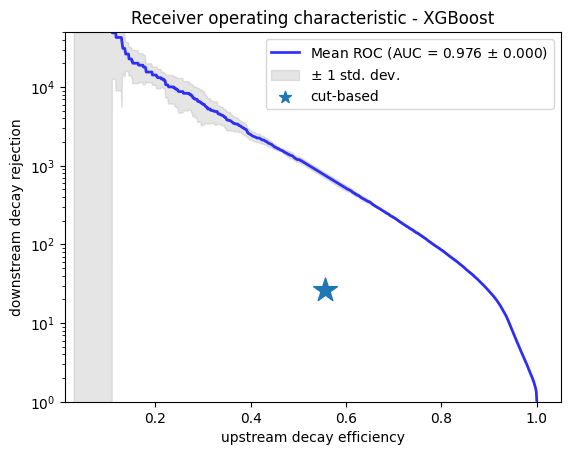

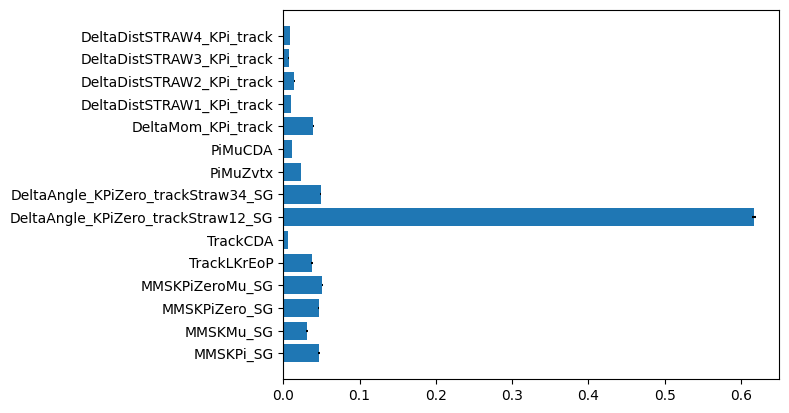

In [49]:
if(outer_cv_opt==0):
    plot_summary_roc(rocs,benchmark)
    plot_summary_featureImportance(feature_importances)

elif(outer_cv_opt==1):
    print(pd.DataFrame(simple_results))

In [50]:
print(bestparams[0])
print(bestparams[1])
print(bestparams[2])
print(bestparams[3])

{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 800}
{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 800}
{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 800}
{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 800}


In [51]:
# Training final model and apply on MC
params = dict(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.01
)

clf = make_pipeline(
    StandardScaler(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state, n_jobs=n_jobs_1, tree_method='hist')
)

clf[1].set_params(**params)
print("final model: ", clf[1])

clf.fit(X, y)
print("\nDone training final model")
y_pred = clf.predict(X)
y_score = clf.predict_proba(X)

final model:  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=2, num_parallel_tree=None,
              predictor=None, random_state=1234, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=None, verbosity=None)

Done training final model


In [52]:
with open("models/up_vs_downstream_bdt.model","wb") as f:
    pickle.dump(clf, f)
clf_loadup = joblib.load(filename="models/up_vs_downstream_bdt.model")
y_score_loadup = clf_loadup.predict_proba(X)

if (np.all(((y_score-y_score_loadup) == 0))):
    print("Model is saved properly.")

Model is saved properly.


In [53]:
# Add the BDT score directly as a new column
df_1pi0region["BDTscore"] = y_score[:, 1]

# Update upstream and downstream selections to include the new column
df_upstream = df_1pi0region[df_1pi0region['up_vs_downstream'] == "upstream"]
df_downstream = df_1pi0region[df_1pi0region['up_vs_downstream'] == "downstream"]

The S/sqrt(S+B) ratio before cuts = 277.01
The S/sqrt(S+B) ratio after optimal BDT score cut @ "BDTscore=0.520" = 422.88


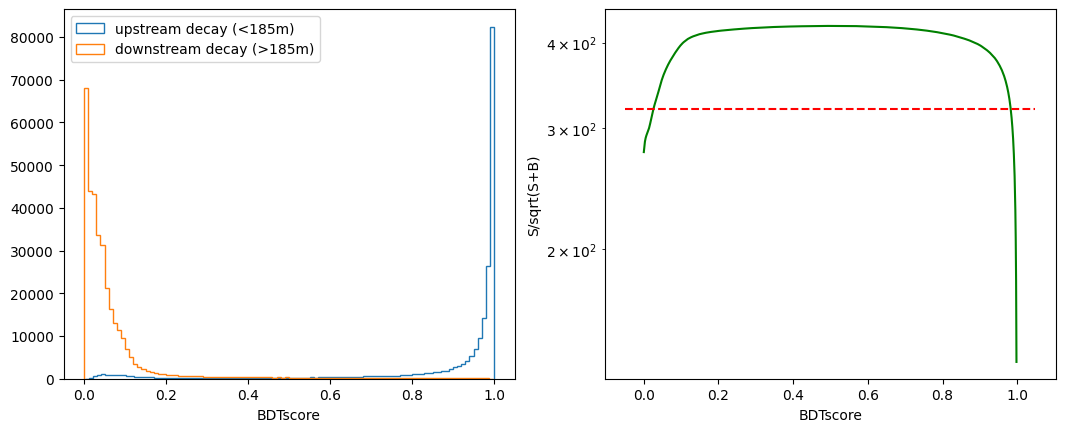

In [54]:
# Obtaining optimal cut on BDT score
print("The S/sqrt(S+B) ratio before cuts = {:.2f}".format(len(df_upstream)/np.sqrt(len(df_upstream)+len(df_downstream))))

maxRatio=1
optimalCut=0
ratio_list=[]
step=0.001
last_valid_idx = None
for idx, cut_val in enumerate(np.linspace(0,1,int(1/step)+1)):
    df_1pi0region_selected=df_1pi0region.loc[(df_1pi0region['BDTscore']>cut_val)]
    df_upstream_selected=df_1pi0region_selected.loc[df_1pi0region['up_vs_downstream']=="upstream"]
    df_downstream_selected=df_1pi0region_selected.loc[df_1pi0region['up_vs_downstream']=="downstream"]
    #Stop once no downstream events pass BDT cut anymore
    if(len(df_downstream_selected)==0):
        last_valid_idx = idx
        break
    ratio=len(df_upstream_selected)/np.sqrt(len(df_upstream_selected)+len(df_downstream_selected))
    ratio_list.append(ratio)
    if(ratio>maxRatio):
        maxRatio=ratio
        optimalCut=cut_val
print("The S/sqrt(S+B) ratio after optimal BDT score cut @ \"BDTscore={:.3f}\" = {:.2f}".format(optimalCut,maxRatio))

# plotting BDT score distribution and the S/B as a fcn of BDT score cut
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.hist(df_upstream['BDTscore'],bins=100,histtype='step')
ax1.hist(df_downstream['BDTscore'],bins=100,histtype='step')
ax1.set_xlabel('BDTscore')
ax1.legend(['upstream decay (<185m)', 'downstream decay (>185m)'])

ax2.plot(np.linspace(0,1,int(1/step)+1)[:last_valid_idx], ratio_list[:last_valid_idx],'g')
ax2.set_ylabel('S/sqrt(S+B)')
ax2.set_xlabel('BDTscore')
ax2.set_yscale('log')
xmin=ax2.get_xlim()[0]
xmax=ax2.get_xlim()[1]
#Plot horizontal line showing the S/sqrt(S+B) ratio for cut based method
plt.hlines(s_over_sqrtsb, xmin, xmax, 'r', '--')

plt.show();
fig.savefig("plot_downstream_pimuDecay_suppression_study/BDTscore.pdf")

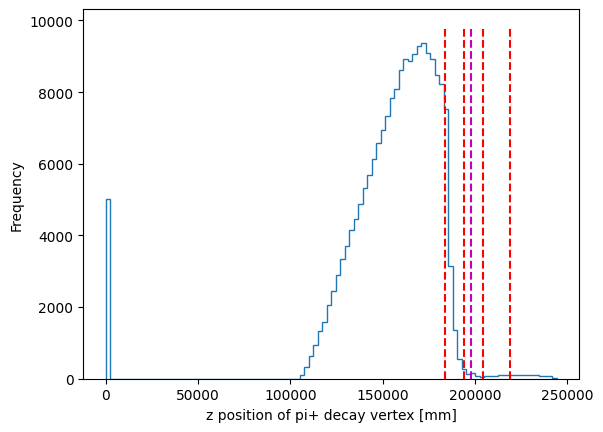

The S/sqrt(S+B) ratio after optimal BDT score cut @ "BDTscore=0.520" = 422.88
    Efficiency of upstream decay events = 91.22%
    Efficiency of downstream decay events = 2.46%


In [55]:
# Plotting the PiMuZvtx after BDT score cut
BDTscore_cut=0.520
df_1pi0region_selected=df_1pi0region.loc[(df_1pi0region['BDTscore']>BDTscore_cut)]
df_upstream_selected=df_1pi0region_selected.loc[df_1pi0region_selected['up_vs_downstream']=="upstream"]
df_downstream_selected=df_1pi0region_selected.loc[df_1pi0region_selected['up_vs_downstream']=="downstream"]
    
ax=df_1pi0region_selected['PiChDecayZvertex'].plot.hist(bins=100,histtype='step')
ax.set_xlabel("z position of pi+ decay vertex [mm]")
ymin=ax.get_ylim()[0]
ymax=ax.get_ylim()[1]
plt.vlines(STRAW1Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW2Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW3Z, ymin, ymax, 'r', '--')
plt.vlines(STRAW4Z, ymin, ymax, 'r', '--')
plt.vlines(MNP33Z, ymin, ymax, 'm', '--')
plt.show();

print("The S/sqrt(S+B) ratio after optimal BDT score cut @ \"BDTscore={:.3f}\" = {:.2f}".format(BDTscore_cut,len(df_upstream_selected)/np.sqrt(len(df_upstream_selected)+len(df_downstream_selected))))
print("    Efficiency of upstream decay events = {:.2f}%".format(100.*len(df_upstream_selected)/len(df_upstream)))
print("    Efficiency of downstream decay events = {:.2f}%".format(100.*len(df_downstream_selected)/len(df_downstream)))
ax.get_figure().savefig("plot_downstream_pimuDecay_suppression_study/pimudecayZvtx_bdt.pdf")

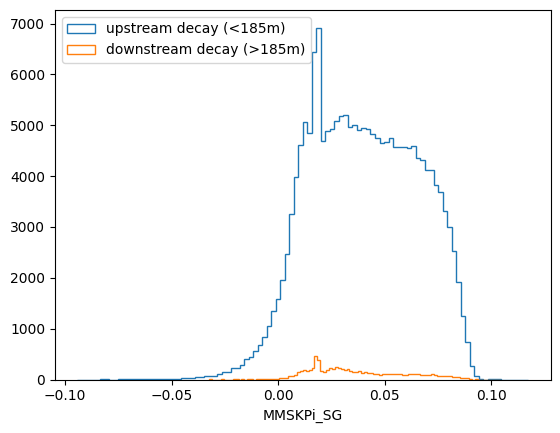

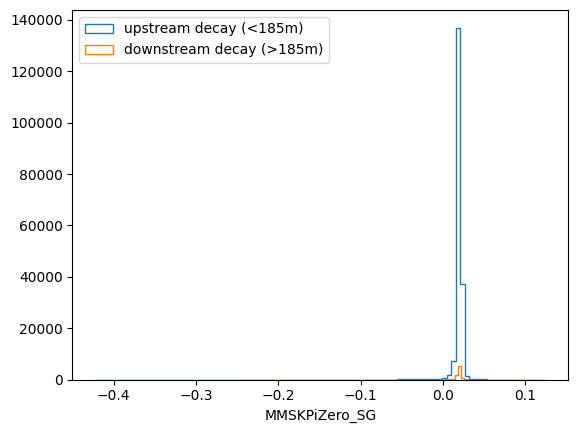

In [56]:
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.hist(df_upstream_selected['MMSKPi_SG'],bins=100,histtype='step')
ax.hist(df_downstream_selected['MMSKPi_SG'],bins=100,histtype='step')
ax.set_xlabel('MMSKPi_SG')
ax.legend(['upstream decay (<185m)', 'downstream decay (>185m)'])

plt.show();

fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.hist(df_upstream_selected['MMSKPiZero_SG'],bins=100,histtype='step')
ax.hist(df_downstream_selected['MMSKPiZero_SG'],bins=100,histtype='step')
ax.set_xlabel('MMSKPiZero_SG')
ax.legend(['upstream decay (<185m)', 'downstream decay (>185m)'])

plt.show();

## Checking how BDT score looks like for Kmu3 events

# Converting the final model from python to C++

In [67]:
import pickle
import numpy as np
import os
import zipfile
# Automatically create Library/bin inside venv to avoid Treelite errors
venv_path = os.getenv('VIRTUAL_ENV')
if venv_path:
    bin_path = os.path.join(venv_path, 'Library', 'bin')
    os.makedirs(bin_path, exist_ok=True)
import treelite

# Load the pipeline
with open("models/up_vs_downstream_bdt.model", "rb") as f:
    clf = pickle.load(f)

# Extract the scalar and the XGB model
scaler = clf.named_steps['standardscaler']
xgb_model = clf.named_steps['xgbclassifier']

# Get the booster and save it to a JSON file (needed for Treelite)
booster = xgb_model.get_booster()

# Export the Treelite model
output_zip = 'bdt_model_pkg.zip'

tl_model = treelite.Model.from_xgboost(booster)
tl_model.export_srcpkg(
    platform='windows',
    toolchain='msvc',
    pkgpath=output_zip,
    libname='predictor',
    options={"language": "c++"}
)

print("Treelite model exported to:", output_zip)

extract_dir = 'bdt_model_pkg'
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted zip to:", extract_dir)

# # Get the scaler parameters
# mean = scaler.mean_
# scale = scaler.scale_

# # Write standardize_sample function into predictor.cc 

# standardize_function = f"""
# // === Automatically added standardize_sample function ===
# #include <vector>
# #include <cmath>

# std::vector<float> standardize_sample(std::vector<float> &sample) {{
#     std::vector<float> standardizer_mean = {{ {", ".join(map(str, mean))} }};
#     std::vector<float> standardizer_scale = {{ {", ".join(map(str, scale))} }};
#     std::vector<float> standardized_sample;
#     for (size_t i = 0; i < sample.size(); i++) {{
#         standardized_sample.push_back((sample[i] - standardizer_mean[i]) / standardizer_scale[i]);
#     }}
#     return standardized_sample;
# }}
# """

# # Append to predictor.cc
# with open(os.path.join(output_dir, 'predictor.cc'), 'a') as f:
#     f.write('\n' + standardize_function)

# print("Added standardize_sample to predictor.cc")

# # Declare standardize_sample in predictor.h 

# header_addition = """
# // === Automatically added function declarations ===
# std::vector<float> standardize_sample(std::vector<float> &sample);
# """

# with open(os.path.join(output_dir, 'predictor.h'), 'a') as f:
#     f.write('\n' + header_addition)

# print("Added function declarations to predictor.h")


[01:01:00] D:\a\treelite\treelite\src\compiler\ast\split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
Treelite model exported to: bdt_model_pkg.zip
Extracted zip to: bdt_model_pkg


In [83]:
import json
import os

# Helper function to export the scalar parameters and XGBoost model
def export_pipeline(clf, output_folder="models"):
    os.makedirs(output_folder, exist_ok=True)

    # Save scaler parameters
    scaler = clf.named_steps['standardscaler']
    means = scaler.mean_.tolist()
    scales = scaler.scale_.tolist()

    print("Scaler parameters:")
    for i, (m, s) in enumerate(zip(means, scales)):
        print(f"Feature {i}: mean = {m:.6f}, scale = {s:.6f}")

    scaler_path = os.path.join(output_folder, "scaler_params.json")
    with open(scaler_path, "w") as f:
        json.dump({"mean": means, "scale": scales}, f)

    # Save XGBoost model as tree-based JSON
    booster = clf.named_steps['xgbclassifier'].get_booster()
    xgb_model_path = os.path.join(output_folder, "xgb_model.json")
    booster.dump_model(xgb_model_path, dump_format="json")

    print(f"\n Scaler and model exported to folder: {output_folder}")

export_pipeline(clf, output_folder="models")

Scaler parameters:
Feature 0: mean = 0.028270, scale = 0.019855
Feature 1: mean = 0.045564, scale = 0.022752
Feature 2: mean = 0.018989, scale = 0.006269
Feature 3: mean = -0.000064, scale = 0.001841
Feature 4: mean = 0.035659, scale = 0.040435
Feature 5: mean = 9.118166, scale = 7.059261
Feature 6: mean = 0.000529, scale = 0.000577
Feature 7: mean = 0.011151, scale = 0.004510
Feature 8: mean = 149023.370993, scale = 60426.974015
Feature 9: mean = 7.318394, scale = 10.778662
Feature 10: mean = 2.905332, scale = 4.560773
Feature 11: mean = 61.227873, scale = 31.070403
Feature 12: mean = 65.260790, scale = 35.097109
Feature 13: mean = 57.836581, scale = 49.602268
Feature 14: mean = 198.020005, scale = 110.346789

 Scaler and model exported to folder: models


In [87]:
import importlib
import convertModel

# Reload the convertModel module to ensure it has the latest changes
importlib.reload(convertModel)

# Use exported json files to generate C++ code for trained model
convertModel.generate_cpp_code(input_folder="models", output_folder="models", output_basename="predictor")

 C++ files successfully written to: models/predictor.h and .cc
